# Momentum Portfolio Analysis

This notebook explores momentum strategies using the ticker returns data stored in the DuckDB database. We will calculate differnt momentum portfolios, and metrics on these portfolios.

This is a draft of what could be implemented:

# Momentum Portfolios
* different rebalancing frequencies (i.e. monthly, quarterly, annually)
* differnt groupings of assets (i.e top/bottom 10%, top/bottom 20%, top/bottom 30%, top/bottom 40%, top/bottom 50%, top/bottom 60%, top/bottom 70%, top/bottom 80%, top/bottom 90%, top/bottom 100%)

# Metrics
* Future Average Returns
* volatility
* Sharpe Ratios
* Market cap distribution
* Correlations/Regressions Analysis:

  Benchmarks Correlations
  Macro Correlations
  Correlations with sentiment indicators

* Portfolio Turnover
* Distribution of Financial Ratios: 

     Book to price ratio, 
     debt to equity ratio, 
     PE
     PEG
     etc

* Option Data: Implied Volatility, skew, put to call ratio.
* Since there tends to be a correlation betwen higher volatiliy and performance of both the long and short sides of the strategy. Adjust the  exposure of the portfolio based on the implied volatility of the stocks held in the portfolio

## 1. Load Data

* Load the returns data from the duckdb created by the yfinance data fetcher for all Equities listed in US Markets

In [1]:
from database_utils import get_available_tickers, load_ticker_data
import duckdb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
tickers = get_available_tickers()
print("Tickers", tickers[:30])
print("Length", len(tickers))

Tickers ['A', 'AA', 'AACB', 'AACBU', 'AACG', 'AAL', 'AAME', 'AAMI', 'AAOI', 'AAON', 'AAP', 'AAPG', 'AAPL', 'AARD', 'AAT', 'AAUC', 'AB', 'ABAT', 'ABBV', 'ABCB', 'ABCL', 'ABEO', 'ABEV', 'ABG', 'ABLV', 'ABM', 'ABNB', 'ABOS', 'ABP', 'ABR']
Length 6330


We have daily returns data for  6330 listed tickers in USA markets through yahoo finance

In [3]:
con = duckdb.connect('../database/market_data.db')
print("Tables in the DB", con.execute("SHOW TABLES").df())
print("-"*60)
print("Number of successful tickers:", con.execute("SELECT COUNT(*) FROM successful_tickers").df())
print("-"*60)
print("Number of failed tickers:", con.execute("SELECT COUNT(*) FROM failed_tickers").df())
print("-"*60)
print("Number of rows in full_history:", con.execute("SELECT COUNT(*) FROM full_history").df())
print("-"*60)
print("see row names")
print(con.execute("SELECT * FROM successful_tickers LIMIT 1").df())
print("-"*60)
print(con.execute("SELECT * FROM failed_tickers LIMIT 1").df())
print("-"*60)
print(con.execute("SELECT * FROM full_history LIMIT 2").df())

Tables in the DB                        name
0         benchmark_returns
1        crsp_daily_returns
2           crsp_delistings
3               crsp_ratios
4            failed_tickers
5  final_crsp_daily_returns
6              full_history
7        successful_tickers
------------------------------------------------------------
Number of successful tickers:    count_star()
0          6330
------------------------------------------------------------
Number of failed tickers:    count_star()
0           364
------------------------------------------------------------
Number of rows in full_history:    count_star()
0      26013191
------------------------------------------------------------
see row names
  ticker
0      A
------------------------------------------------------------
  ticker         error
0  AACBR  Empty result
------------------------------------------------------------
                 date       open       high        low      close    volume  \
0 1999-11-18 14:30:00  3

In [4]:
# Select the tickers we want to include in the universe
def query(query: str): 
    #helper to query duckdb
    return con.execute(query).df()

def select_tickers_listed():
    """
    python
    Selects tickers from the history that were listed after a specific date 
    and maintain a minimum initial close price.

    Args:
        start_date (str): The earliest listing date to filter by (YYYY-MM-DD).
        min_close_price (int): The minimum close price required at the listing date.
    """
    q = f"""
        SELECT DISTINCT crsp_company_id 
        FROM final_crsp_daily_returns
    """

    return query(q)


    print(len(tickers))
    print(tickers[:10])

#select_tickers_listed_from_start_date('2010-02-01', 5)

We have the daily data for 3022 tickers for stocks that have been trading for over 10 years in US markets

## 2 Functions to construct portfolio

In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from typing import List, Union, Tuple, Optional


class MomentumPortfolio:
    """
    Constructs and backtests a momentum-based portfolio using historical return data.
    """
    
    def __init__(self, START_DATE_LISTED: str, MIN_AVG_LISTED_PRICE: float, START_TIME: str, AGREGATION_PREIOD_OF_RETURNS: str, CLIP_EXTREME_RETURNS: bool, PERCENTILES: list, LOOKBACK_PERIOD: int, LAST_PERIODS_TO_IGNORE: int, INVESTABLE_BIRTH_PERIODS: int, MIN_INCLUDE_PRICE: float):
        self.log_returns: pd.DataFrame = None # this holds the returns of stocks
        self.weights: pd.DataFrame = None # this holds the weights of the portfolio during each period. computing the wighets dictates the behavior of the portfolioC
        self.performance: pd.DataFrame = None # This is the result of simulating the resturns of the portfolio over time by using the pre computed weights and returns of each stock during the HPR
        self.tickers: List[str] = [] # These are the tickers that qualify for the strategy and we use
        self.percentile_results: dict = {}
        self.periods_per_year = None
        self.prices: pd.DataFrame = None
        self.num_portfolio_holdings: list(pd.DataFrame) = None

        def run_all():
            tickers = select_tickers_listed()
            # 3. Load the returns data for desired ticekt into memory for the desired time period 
            self.fetch_data(
                tickers=tickers,
                time_start=START_TIME,
                aggregate=AGREGATION_PREIOD_OF_RETURNS,
                clip_extreme_values=CLIP_EXTREME_RETURNS,
            )
            # 4. Pre compute weights for each eprcentile ranges, using a lookback period, and periods to ignore
            self.construct_performances_for_percentiles(PERCENTILES, LOOKBACK_PERIOD, LAST_PERIODS_TO_IGNORE, INVESTABLE_BIRTH_PERIODS, MIN_INCLUDE_PRICE)
            # 4. Plot results
            self.plot_portfolios_over_HPR()
            self.plot_portfolio_average_returns()
            self.plot_portfolio_standard_deviations()
            self.print_portfolio_statistics()
            self.plot_num_holdings()

        run_all()
        # allows to run the function from outside the class although it's set to auto run currently
        self.run_all = run_all


    def fetch_data(self, tickers: Union[List[str], pd.DataFrame, pd.Series], time_start: str, aggregate: Optional[str] = None, clip_extreme_values: bool = False) -> None:
        """
        This Loads the data for the tickets you pass from the local duck db, for the time period you pass
        the script runs too slow try reducing the time period to use less memory
        """
        if isinstance(tickers, pd.DataFrame):
            self.tickers = tickers.iloc[:, 0].dropna().unique().tolist()
        elif isinstance(tickers, pd.Series):
            self.tickers = tickers.dropna().unique().tolist()
        else:
            self.tickers = list(set(tickers))

        if not self.tickers:
            print("Warning: No valid tickers provided. Data fetch aborted.")
            return

        if len(self.tickers) == 1:
            tickers_str = f"('{self.tickers[0]}')"
        else:
            tickers_str = str(tuple(self.tickers))
        # crsp_company_id as ticker due to name change of tickers for company listings 
        q = f"""
            SELECT 
                date, 
                log_return_1 as log_return, 
                exchange_code,
                price, 
                crsp_company_id as ticker,
                -- This calculates the 'birth date' for each company globally
                MIN(date) OVER(PARTITION BY crsp_company_id) as first_listed_date
            FROM final_crsp_daily_returns 
            WHERE crsp_company_id IN {tickers_str} 
            AND date > '{time_start}'
        """
        
        raw_data = query(q)
        

        # Store the Metadata Map BEFORE pivoting
        # This ensures every ticker is mapped to its birth date
        self.first_listed_dates = raw_data.groupby('ticker')['first_listed_date'].first()
        self.first_listed_dates = pd.to_datetime(self.first_listed_dates)

        ## save prices data after pivoting 
        self.prices = raw_data.pivot(index='date', columns='ticker', values='price').abs() 
        self.prices.index = pd.to_datetime(self.prices.index)
            
        # convert the returns data to wide column format, keeping just dates and log returns for all tickers
        self.log_returns = raw_data.pivot(index='date', columns='ticker', values='log_return')
        self.log_returns.index = pd.to_datetime(self.log_returns.index)
        


        if aggregate:
            self.log_returns = self.log_returns.resample(aggregate).sum(min_count=1)
            
            # 2. Limit the forward fill to 1 month so dead stocks actually vanish
            self.prices = self.prices.resample(aggregate).last().ffill(limit=1)
            self.prices = self.prices.reindex(self.log_returns.index).ffill(limit=1)
            if aggregate == "ME":
                self.periods_per_year = 12
            else:
                raise ValueError(f"Aggreation period of: {aggregate} is not supported. though it can be added if it is compatible with pandas, ask Julen Marmol, this value is used to compute portfolio nstatistics later on")
        if False:
            self.log_returns = self.log_returns.replace([np.inf, -np.inf], np.nan)
            self.log_returns = self.log_returns.clip(lower=-0.8, upper=0.8)  

    def compute_weight_momentum_12_minus_1(self, top_percentile: float, bottom_percentile: float = 0, 
                                           long_window: int = 12, short_window: int = 1, investable_birth_periods: int = 60, min_include_price: float = 5.0) -> None:
        """
        THis is the engine of the portfolio, it computes the weights of the portfolio based on the momentum of the stocks 
        and simulates the weights you have to alocate to alocate stocks of a selected percentile range based on the 
        momentum methodology into the portdolio.
        You can adjust how many periods to ignore, and how long the lookback period is.

        investable_birth_periods: the number of periods company needs to have been listed to be considered investable by the portfolio
        """
        if self.log_returns is None:
            raise ValueError("Data not fetched. Call fetch_data() first.")
        r = self.log_returns.shift(1) 
        long_return = r.rolling(window=long_window).sum()
        short_return = r.rolling(window=short_window).sum()
        momentum_signal = long_return - short_return

        rows = []

        start_p = min(top_percentile, bottom_percentile)
        end_p = max(top_percentile, bottom_percentile)

        for date, row_signal in momentum_signal.iterrows():
            if row_signal.isnull().all():
                continue
            # filter out assets that have not been listed for the required number of periods
            # Define the "Age" threshold for this specific trading date
            date_exist_threshold = date - pd.DateOffset(months=investable_birth_periods)
            # Identify tickers that were born BEFORE the threshold
            eligible_tickers = self.first_listed_dates[self.first_listed_dates <= date_exist_threshold].index
            # Filter the current signal row to only include eligible companies
            row_signal = row_signal[row_signal.index.isin(eligible_tickers)]

            current_prices = self.prices.loc[date]
            price_eligible = current_prices[current_prices >= min_include_price].index
            row_signal = row_signal[row_signal.index.isin(price_eligible)]

            # sort the row by momentum signal to order by percentile signal
            sorted_row = row_signal.sort_values(ascending=True)
            valid_assets = sorted_row.dropna()
            l = len(valid_assets)
            
            if l == 0: 
                continue
            
            start_idx = int(start_p * l / 100)
            end_idx = int(end_p * l / 100)
            
            if start_idx == end_idx and end_idx < l:
                end_idx += 1
                
            selected_tickers = valid_assets.index[start_idx:end_idx].tolist()

            if not selected_tickers:
                rows.append({"date": date})
                continue
                
            weight_value = 1.0 / len(selected_tickers)
            ticker_to_weight = {ticker: 0.0 for ticker in sorted_row.index}
            
            for t in selected_tickers:
                ticker_to_weight[t] = weight_value
            
            ticker_to_weight["date"] = date
            rows.append(ticker_to_weight)
            
        self.weights = pd.DataFrame(rows)
        if not self.weights.empty:
                self.weights.set_index("date", inplace=True)
                
    
    def plot_num_holdings(self) -> None:
        """
        Plots the historical count of stocks (the 'sum' of holdings) for each strategy.
        """

        #. Plot the Universe Size (Number of Holdings / Capacity)
        plt.figure(figsize=(12, 6))
        for name, df in self.percentile_results.items():
            plt.plot(df.index, df['num_holdings'], label=f"{name} Holdings")
        
        plt.title("Portfolio Capacity: Number of Holdings Over Time")
        plt.xlabel("Date")
        plt.ylabel("Stock Holdings Count")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def compute_index_level_and_returns(self, start_index: float = 100.0) -> pd.DataFrame:
        if self.weights is None or self.weights.empty:
            return pd.DataFrame() 

        # 1. Execution Lag & Shape Alignment
        effective_weights = self.weights.shift(1).reindex_like(self.log_returns).fillna(0)
        
        # 2. Prepare Simple Returns
        simple_returns = np.exp(self.log_returns).copy() - 1
        
        # 3. Delisting Penalty (-100% loss if weight > 0 but return is NaN)
        # This is your key defense against survivorship bias
        # not good to use when we have real delisting data
        #missing_returns_mask = (effective_weights > 0) & (self.log_returns.isna())
        #simple_returns[missing_returns_mask] = -1.0
        
        # 4. Calculate weighted portfolio returns
        weighted_returns_matrix = effective_weights * simple_returns
        weighted_simple_returns = weighted_returns_matrix.fillna(0).sum(axis=1)
        
        # 5. Build Performance DataFrame
        perf = pd.DataFrame(index=self.log_returns.index)
        perf = pd.DataFrame(index=self.log_returns.index)

        # Clip the LOSS at -99.9% so ln(0) never happens
        # This turns -infinity into a "very large loss" that you can recover from eventually
        #perf['portfolio_simple_return'] = weighted_simple_returns.clip(lower=-0.999) 
        perf['portfolio_simple_return'] = weighted_simple_returns

        
        # Clean up warm-up periods
        perf.dropna(subset=['portfolio_simple_return'], inplace=True)
        # Only start tracking when the strategy actually has its first trade
        first_trade_idx = (perf['portfolio_simple_return'] != 0).idxmax()
        perf = perf.loc[first_trade_idx:].copy()
        
        # 6. Compound Math
        # Handle negative natural logarithms (Extreme negative retruns. do not blow up)
        perf['portfolio_log_return'] = np.where(
            perf['portfolio_simple_return'] > -1,
            np.log1p(perf['portfolio_simple_return']),
            np.nan
        )
        perf['cumulative_log_return'] = perf['portfolio_log_return'].cumsum()
        perf['index_level'] = start_index * np.exp(perf['cumulative_log_return'])  

        # debug
        """
        num_penalties = missing_returns_mask.sum().sum()
        held_count = (effective_weights > 0).sum(axis=1)
        penalty_count = missing_returns_mask.sum(axis=1)
        penalty_frac = (penalty_count / held_count.replace(0, np.nan)).fillna(0)
        print("Penalty stats:")
        print("  avg held names:", held_count[held_count > 0].mean())
        print("  total penalties:", int(penalty_count.sum()))
        print("  avg penalty frac:", penalty_frac.mean())
        print("  max penalty frac:", penalty_frac.max())

        if num_penalties > 0:
            print(f"DEBUG: Applied {num_penalties} delisting penalties in this run.")      
            """
        return perf

    def construct_performances_for_percentiles(self, percentiles: List[Union[List[float], Tuple[float, float]]], long_window, short_window, investable_birth_periods: int = 60, min_include_price: int = 5) -> None:
        """
        This creates the performance for a list of percentile ranges in tuple format,
        load returns data first.

        percentiles = [(0,10),(10,20),(20,30),...]
        """
        if self.log_returns is None:
            raise ValueError("Data not loaded. Please call fetch_data() first.")

        self.percentile_results = {}
        #self.weights_by_strategy = {}

        for top_p, bottom_p in percentiles:
            self.compute_weight_momentum_12_minus_1(
                top_percentile=top_p, 
                bottom_percentile=bottom_p, 
                long_window=long_window, 
                short_window=short_window, 
                investable_birth_periods=investable_birth_periods, 
                min_include_price=min_include_price
            )
            
            start_p = min(top_p, bottom_p)
            end_p = max(top_p, bottom_p)
            key_name = f"Percentile {start_p}% to {end_p}%"

            # SAVE weights snapshot
            weights_snapshot = self.weights.copy()
            #self.weights_by_strategy[key_name] = weights_snapshot

            perf_df = self.compute_index_level_and_returns().copy()

            # Compute holdings from the correct weights
            effective_weights = weights_snapshot.shift(1).reindex_like(self.log_returns).fillna(0)
            current_holdings_count = (effective_weights != 0).sum(axis=1)
            perf_df['num_holdings'] = current_holdings_count.reindex(perf_df.index).fillna(0)

            self.percentile_results[key_name] = perf_df.copy()



    def construct_portfolio_average_holding_period_returns(self) -> pd.Series:
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return pd.Series(dtype=float)

        stats = {name: df['portfolio_log_return'].mean() 
                 for name, df in self.percentile_results.items() if not df.empty}
            
        return pd.Series(stats, name="Average HPR (Log)")
    
    def construct_portfolio_average_standard_deviation_for_holding_period_return(self) -> pd.Series:
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return pd.Series(dtype=float)

        stats = {name: df['portfolio_log_return'].std() 
                 for name, df in self.percentile_results.items() if not df.empty}
            
        return pd.Series(stats, name="Std Dev HPR (Log)")

    def plot_portfolios_over_HPR(self) -> None:
        if not self.percentile_results:
            print("No performances to plot.")
            return

        plt.figure(figsize=(12, 6))
        
        for name, df in self.percentile_results.items():
            if not df.empty:
                plt.plot(df.index, df['index_level'], label=name)
            
        plt.title("Momentum Portfolio Performance Comparison")
        plt.xlabel("Date")
        plt.ylabel("Index Level")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_portfolio_average_returns(self, return_type: str = "simple") -> None:
        avg_log_returns = self.construct_portfolio_average_holding_period_returns()
        
        if avg_log_returns.empty:
            print("No data to plot.")
            return

        if return_type == "simple":
            avg_returns = np.exp(avg_log_returns) - 1
            ylabel = "Average Simple Return (%)"
        elif return_type == "log":
            avg_returns = avg_log_returns
            ylabel = "Average Log Return (%)"
        else:
            raise ValueError("return_type must be 'simple' or 'log'")

        plt.figure(figsize=(10, 6))
        avg_returns.plot(kind='bar', alpha=0.8)

        plt.title("Average Holding Period Return by Strategy Slice")
        plt.xlabel("Strategy Selection")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha='right')

        plt.gca().yaxis.set_major_formatter(
            plt.FuncFormatter(lambda y, _: f"{y*100:.2f}%")
        )

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()


    def plot_portfolio_standard_deviations(self) -> None:
        std_devs = self.construct_portfolio_average_standard_deviation_for_holding_period_return()
        
        if std_devs.empty:
            print("No data to plot.")
            return

        plt.figure(figsize=(10, 6))
        std_devs.plot(kind='bar', color='salmon', alpha=0.8)
        
        plt.title("Volatility (Std Dev) by Strategy Slice")
        plt.xlabel("Strategy Selection")
        plt.ylabel("Standard Deviation of Returns")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def print_portfolio_statistics(self, risk_free_rate: float = 0.0) -> None:
        """
        Calculates and prints absolute performance metrics (Sharpe, Max Drawdown) 
        and plots the 12-month rolling volatility for all stored strategies.
        """
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return

        stats_list = []
        
        plt.figure(figsize=(12, 6))
        
        for name, df in self.percentile_results.items():
            if df.empty:
                continue
                
            returns = df['portfolio_simple_return']
            
            # --- THE FIX: ADD 'self.' TO PERIODS_PER_YEAR ---
            # Annualized Return & Volatility
            n_periods = len(returns.dropna())
            # Geometric anualized returns
            ann_return = (1 + returns).prod() ** (self.periods_per_year / n_periods) - 1
            ann_vol = returns.std() * np.sqrt(self.periods_per_year)
            
            # Sharpe Ratio
            sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol != 0 else 0
            
            # Max Drawdown
            cum_ret = (1 + returns).cumprod()
            rolling_max = cum_ret.cummax()
            drawdown = cum_ret / rolling_max - 1
            max_drawdown = drawdown.min()
            
            # Add to table
            stats_list.append({
                "Strategy": name,
                "Ann. Return": f"{ann_return*100:.2f}%",
                "Ann. Volatility": f"{ann_vol*100:.2f}%",
                "Sharpe Ratio": f"{sharpe:.2f}",
                "Max Drawdown": f"{max_drawdown*100:.2f}%"
            })
            
            rolling_vol = returns.rolling(window=self.periods_per_year).std() * np.sqrt(self.periods_per_year)
            plt.plot(df.index, rolling_vol, label=name)

        # Print the clean stats table
        stats_df = pd.DataFrame(stats_list)
        print("\n--- Absolute Portfolio Statistics ---")
        print(stats_df.to_string(index=False))
        print("-" * 45)
        
        # Display the Volatility Plot
        plt.title(f"Rolling Volatility (Annualized)")
        plt.ylabel("Annualized Volatility")
        plt.xlabel("Date")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Extensions with Inheritance

In [6]:
class LongShortMomentumPortfolio(MomentumPortfolio):
    """
    Inherits from MomentumPortfolio.
    Adds Long/Short construction and Benchmark evaluation.
    """
    def __init__(
        self,
        START_DATE_LISTED: str,
        MIN_AVG_LISTED_PRICE: float,
        START_TIME: str,
        AGREGATION_PREIOD_OF_RETURNS: str,
        CLIP_EXTREME_RETURNS: bool,
        LOOKBACK_PERIOD: int,
        LAST_PERIODS_TO_IGNORE: int,
        INVESTABLE_BIRTH_PERIODS: int,
        MIN_INCLUDE_PRICE: float,
        LONG_PERCENTILE: tuple,
        SHORT_PERCENTILE: tuple,
        LONG_WEIGHT: float,
        SHORT_WEIGHT: float,
        BENCHMARK: str,
    ):
        def _init_base_state():
            self.log_returns = None
            self.weights = None
            self.performance = None
            self.tickers = []
            self.percentile_results = {}
            self.periods_per_year = None
            self.prices = None
            self.num_portfolio_holdings = None
        _init_base_state()
        self.benchmark_data: pd.DataFrame = None


        def run_ls_portfolio():
            tickers = select_tickers_listed()
            self.fetch_data(tickers=tickers, time_start=START_TIME, aggregate=AGREGATION_PREIOD_OF_RETURNS, clip_extreme_values=CLIP_EXTREME_RETURNS)
            self.fetch_benchmark(BENCHMARK, START_TIME, AGREGATION_PREIOD_OF_RETURNS)
            self.construct_long_short_portfolio(LONG_PERCENTILE, SHORT_PERCENTILE, LONG_WEIGHT, SHORT_WEIGHT)
            self.evaluate_against_benchmark()
            self.plot_portfolios_over_HPR()
            self.plot_portfolio_average_returns()
            self.plot_portfolio_standard_deviations()
            self.print_portfolio_statistics()
            self.print_relative_statistics()

        run_ls_portfolio()
        
    def construct_long_short_portfolio(self, 
                                       long_percentile: Tuple[float, float], 
                                       short_percentile: Tuple[float, float],
                                       long_weight: float = 1.0, 
                                       short_weight: float = -1.0,
                                       long_window: int = 12, 
                                       short_window: int = 1) -> pd.DataFrame:
        """
        Calculates weights for the long leg and the short leg separately, 
        multiplies them by their allocation size, and merges them into a single portfolio.
        """
        # 1. Compute and extract Long weights
        self.compute_weight_momentum_12_minus_1(top_percentile=long_percentile[0], 
                                                bottom_percentile=long_percentile[1], 
                                                long_window=long_window, 
                                                short_window=short_window)
        long_w = self.weights.copy()
        
        # 2. Compute and extract Short weights
        self.compute_weight_momentum_12_minus_1(top_percentile=short_percentile[0], 
                                                bottom_percentile=short_percentile[1], 
                                                long_window=long_window, 
                                                short_window=short_window)
        short_w = self.weights.copy()
        
        # 3. Merge weights using pandas .add() with fill_value=0.0 to handle non-overlapping tickers
        combined_weights = (long_w * long_weight).add((short_w * short_weight), fill_value=0.0)
        
        # 4. Overwrite self.weights with the combined Long/Short matrix
        self.weights = combined_weights
        
        # 5. Run the base class performance calculator
        perf = self.compute_index_level_and_returns()
        
        self.performance = perf.copy()

        
        # Store for the plot loops
        key_name = f"L: {long_percentile}% ({long_weight}x) / S: {short_percentile}% ({short_weight}x)"
        self.percentile_results[key_name] = perf.copy()
        
        return perf

    def fetch_benchmark(self, ticker: str, time_start: str, aggregate: str = "ME"):
        """Fetches a single ticker to use as the baseline index."""
        q = f"""
        SELECT date, log_return 
        FROM benchmark_returns 
        WHERE benchmark_name = '{ticker}' 
        AND date > '{time_start}'
        """
        raw_data = query(q) # Uses your global query function
        raw_data.set_index('date', inplace=True)
        raw_data.index = pd.to_datetime(raw_data.index)
        
        if aggregate:
            self.benchmark_data = raw_data.resample(aggregate).sum()
        else:
            self.benchmark_data = raw_data

    def evaluate_against_benchmark(self):
        """
        Calculates Beta, Correlation, and plots the Strategy vs Benchmark.
        Requires construct_long_short_portfolio() and fetch_benchmark() to be run first.
        """
        if self.performance is None or self.benchmark_data is None:
            raise ValueError("Ensure both strategy performance and benchmark data are loaded.")

        # 1. Align the Strategy Simple Returns and Benchmark Simple Returns
        strat_returns = self.performance['portfolio_simple_return']
        bench_simple = np.exp(self.benchmark_data['log_return']) - 1 # Convert log to simple
        
        aligned = pd.concat([strat_returns, bench_simple], axis=1, join='inner').dropna()
        aligned.columns = ['Strategy', 'Benchmark']

        # 2. Calculate Beta and Correlation
        # Beta = Cov(Rp, Rb) / Var(Rb)
        cov_matrix = np.cov(aligned['Strategy'], aligned['Benchmark'])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        
        correlation = aligned['Strategy'].corr(aligned['Benchmark'])
        
        print(f"--- Statistics vs Benchmark ---")
        print(f"Beta: {beta:.4f}")
        print(f"Correlation: {correlation:.4f}")

        # 3. Create Benchmark Index (Base 100)
        aligned['Bench_Cum_Log'] = np.log(1 + aligned['Benchmark']).cumsum()
        aligned['Bench_Index'] = 100 * np.exp(aligned['Bench_Cum_Log'])

        # 4. Plot Cumulative Growth
        plt.figure(figsize=(12, 6))
        plt.plot(self.performance.index, self.performance['index_level'], label='Strategy', color='blue')
        plt.plot(aligned.index, aligned['Bench_Index'], label='Benchmark', color='black', linestyle='--')
        plt.title("Long/Short Strategy vs. Benchmark")
        plt.ylabel("Index Level (Start=100)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 5. Plot 12-Month Rolling Correlation
        rolling_corr = aligned['Strategy'].rolling(window=12).corr(aligned['Benchmark'])
        
        plt.figure(figsize=(12, 4))
        rolling_corr.plot(color='purple')
        plt.axhline(0, color='black', linewidth=1)
        plt.title("12-Month Rolling Correlation vs Benchmark")
        plt.ylabel("Correlation Coefficient")
        plt.grid(True, alpha=0.3)
        plt.show()

    def print_relative_statistics(self, risk_free_rate: float = 0.0) -> None:
        """
        Calculates relative metrics (Alpha, Information Ratio, Tracking Error)
        for the active strategy against the loaded benchmark.
        """
        if self.performance is None or self.benchmark_data is None:
            raise ValueError("Ensure strategy performance and benchmark data are loaded.")
            
        strat_returns = self.performance['portfolio_simple_return']
        bench_simple = np.exp(self.benchmark_data['log_return']) - 1 
        
        # Align dates
        aligned = pd.concat([strat_returns, bench_simple], axis=1, join='inner').dropna()
        aligned.columns = ['Strategy', 'Benchmark']
        
        if aligned.empty:
            print("No overlapping data between strategy and benchmark.")
            return

        # --- THE FIX: Removed hardcoded periods_per_year = 12 ---
        
        # 1. Annualize Returns (Using the dynamic self.periods_per_year)
        strat_ann_ret = (1 + aligned['Strategy'].mean()) ** self.periods_per_year - 1
        bench_ann_ret = (1 + aligned['Benchmark'].mean()) ** self.periods_per_year - 1
        
        # 2. Beta
        cov_matrix = np.cov(aligned['Strategy'], aligned['Benchmark'])
        # Safety check to prevent dividing by zero if the benchmark never moves
        beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else 0
        
        # 3. Jensen's Alpha (Annualized)
        # Formula: Strat Return - [Risk Free + Beta * (Bench Return - Risk Free)]
        expected_return = risk_free_rate + beta * (bench_ann_ret - risk_free_rate)
        alpha = strat_ann_ret - expected_return 
        
        # 4. Tracking Error & Information Ratio
        active_returns = aligned['Strategy'] - aligned['Benchmark']
        tracking_error = active_returns.std() * np.sqrt(self.periods_per_year)
        
        # The Information Ratio quantifies the excess portfolio returns over the returns of a benchmark, relative to the volatility of the excess returns.
        information_ratio = (strat_ann_ret - bench_ann_ret) / tracking_error if tracking_error != 0 else 0
        
        print("\n--- Relative Statistics (vs Benchmark) ---")
        # Jensen's Alpha is the original alpha, showing the portfolio's return above the expected return generated using the CAPM.
        print(f"Annualized Alpha:   {alpha*100:.2f}%")
        print(f"Beta:               {beta:.2f}")
        print(f"Information Ratio:  {information_ratio:.2f}")
        print(f"Tracking Error:     {tracking_error*100:.2f}%")
        print("-" * 50)
        print(f"Strategy Ann. Ret:  {strat_ann_ret*100:.2f}%")
        print(f"Benchmark Ann. Ret: {bench_ann_ret*100:.2f}%")
        print("-" * 50)

### Utilities

In [7]:
def download_crsp_benchmark_to_duckdb(
    benchmark_name: str = "SPY",
    start_date: str = "1950-01-01",
    end_date: str = "2026-01-01",
):
    """
    Download benchmark daily returns from WRDS CRSP and store in DuckDB table `benchmark_returns`.

    Parameters
    ----------
    benchmark_name : str
        Name to store in the benchmark table (e.g., 'CRSP_VWRETD', 'CRSP_EWRETD').
    start_date : str
        Start date inclusive (YYYY-MM-DD).
    end_date : str
        End date exclusive (YYYY-MM-DD).
    wrds_conn : wrds.Connection
        Active WRDS connection.
    duckdb_conn : duckdb.DuckDBPyConnection
        Active DuckDB connection.
    """
    import wrds
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wrds_conn = wrds.Connection(
    wrds_username=os.getenv("WRDS_USER"), wrds_password=os.getenv("WRDS_PASSWORD"))


    duckdb_conn = con
    
    if wrds_conn is None:
        raise ValueError("wrds_conn is required")
    if duckdb_conn is None:
        raise ValueError("duckdb_conn is required")

    # Pull benchmark from CRSP daily stock indexes table
    # dsi fields usually include vwretd / ewretd
    q = f"""
        SELECT
            date,
            vwretd AS simple_return,
            CASE
                WHEN vwretd IS NULL THEN NULL
                WHEN vwretd > -1 THEN LN(1 + vwretd)
                ELSE NULL
            END AS log_return
        FROM crsp.dsi
        WHERE date >= '{start_date}'
        ORDER BY date
    """

    df = wrds_conn.raw_sql(q)

    # Add benchmark metadata column
    df["benchmark_name"] = benchmark_name

    # Reorder columns for consistency
    df = df[["date", "benchmark_name", "simple_return", "log_return"]]

    # Ensure target table exists
    duckdb_conn.execute("""
        CREATE TABLE IF NOT EXISTS benchmark_returns (
            date DATE,
            benchmark_name VARCHAR,
            simple_return DOUBLE,
            log_return DOUBLE
        )
    """)

    # Delete existing rows for this benchmark in the requested date range to avoid duplicates
    duckdb_conn.execute(f"""
        DELETE FROM benchmark_returns
        WHERE benchmark_name = '{benchmark_name}'
          AND date >= '{start_date}'
          AND date < '{end_date}'
    """)

    # Insert new rows
    duckdb_conn.register("benchmark_df", df)
    duckdb_conn.execute("""
        INSERT INTO benchmark_returns
        SELECT date, benchmark_name, simple_return, log_return
        FROM benchmark_df
    """)
    duckdb_conn.unregister("benchmark_df")

    print(f"Saved {len(df)} rows for benchmark {benchmark_name}")

def download_benchmark_to_duckdb_yfinance(benchmark_name: str = "SPY"):
    """
    Download benchmark price history using your yfinance utility and store returns in DuckDB
    table `benchmark_returns`.

    Uses: data_downloaders.yfinance_api.fetch_ticker_data
    Expects `con` (DuckDB connection) to exist in scope.
    """
    import sys
    import os
    import numpy as np
    import pandas as pd

    # Import your helper from ../data_downloaders
    sys.path.append(os.path.abspath(".."))
    from data_downloaders.yfinance_api import fetch_ticker_data

    # Fetch data (usually OHLCV with DatetimeIndex)
    df = fetch_ticker_data(benchmark_name)

    if df is None or df.empty:
        raise ValueError(f"No data returned for benchmark {benchmark_name}")

    # Normalize date column
    df = df.reset_index()
    if "Date" in df.columns:
        df = df.rename(columns={"Date": "date"})
    elif "index" in df.columns:
        df = df.rename(columns={"index": "date"})

    # Find close column robustly
    close_col = None
    for c in ["Adj Close", "adj_close", "Close", "close"]:
        if c in df.columns:
            close_col = c
            break
    if close_col is None:
        raise ValueError(
            f"Could not find a close price column for {benchmark_name}. "
            f"Columns found: {list(df.columns)}"
        )

    # Keep only needed columns, sort, and compute returns
    out = df[["date", close_col]].copy()
    out["date"] = pd.to_datetime(out["date"]).dt.date
    out = out.sort_values("date").drop_duplicates(subset=["date"])
    out = out.rename(columns={close_col: "close_price"})

    out["simple_return"] = out["close_price"].pct_change()
    out["log_return"] = np.where(
        out["simple_return"].notna() & (out["simple_return"] > -1),
        np.log1p(out["simple_return"]),
        np.nan,
    )
    out["benchmark_name"] = benchmark_name

    # Final schema order
    out = out[["date", "benchmark_name", "simple_return", "log_return"]]

    # Create table if needed
    con.execute("""
        CREATE TABLE IF NOT EXISTS benchmark_returns (
            date DATE,
            benchmark_name VARCHAR,
            simple_return DOUBLE,
            log_return DOUBLE
        )
    """)

    # Delete existing rows for this benchmark to avoid duplicates
    con.execute(f"""
        DELETE FROM benchmark_returns
        WHERE benchmark_name = '{benchmark_name}'
    """)

    # Insert into DuckDB
    con.register("benchmark_df", out)
    con.execute("""
        INSERT INTO benchmark_returns (date, benchmark_name, simple_return, log_return)
        SELECT date, benchmark_name, simple_return, log_return
        FROM benchmark_df
    """)
    con.unregister("benchmark_df")

    print(f"Saved {len(out)} rows for benchmark {benchmark_name}")
    return out



# 3 Usage of the Momentum Portfolio class

# Metrics that can be modifed:

In [8]:
START_TIME = "1970-01-01"

# this can either be: 1. "ME" for monthly aggregation(month end), 2. DE Day end, 3. QE Quarter end, 4. SE every 6 months end, 5. UE year end
# Changing this changes the rebalancing period of the portfolio, to change how far we look back for performance change 
AGREGATION_PREIOD_OF_RETURNS = "ME" 

PERCENTILES = [
    (0,10), 
    (10,20), 
    (20,30), 
    (30,40), 
    (40,50),
    (50,60), 
    (60,70), 
    (70,80), 
    (80,90), 
    (90,100)
]
# this date is the cutoff, stocks that were not listed before these date will not be used in the porfolio
START_DATE_LISTED = '2019-02-01'

# price cutoff to not use stocks that had an average closing price of this amount
# should be care ful with this as it can introduce survivorship bias into the portfolio
# it can be changed to be included in the logic of the porfolio, don't include a stock when it's bellow this price
MIN_AVG_LISTED_PRICE = 5

# Lookback Period
LOOKBACK_PERIOD = 12
LAST_PERIODS_TO_IGNORE = 1 

# Clip Extreme Returns ?
# Ignoring extreme results is necessary for meomentung to work, it would change the predictability of the strategy.
# Short squeezes cause random explosions, weights of penny stocks that are bought out distort what the espected returns would be
# We can think of this as setting a stop loss on the daily losses in a single asset, though it also affects the upside 
CLIP_EXTREME_RETURNS = False

# Number of periods company needs to have existed to be considered investable for the portfoliop
INVESTABLE_BIRTH_PERIODS = 60


# Sell or not own when price is lower than
MIN_INCLUDE_PRICE = 5



# Momentum Portfolio Class Usage
## Since 1970

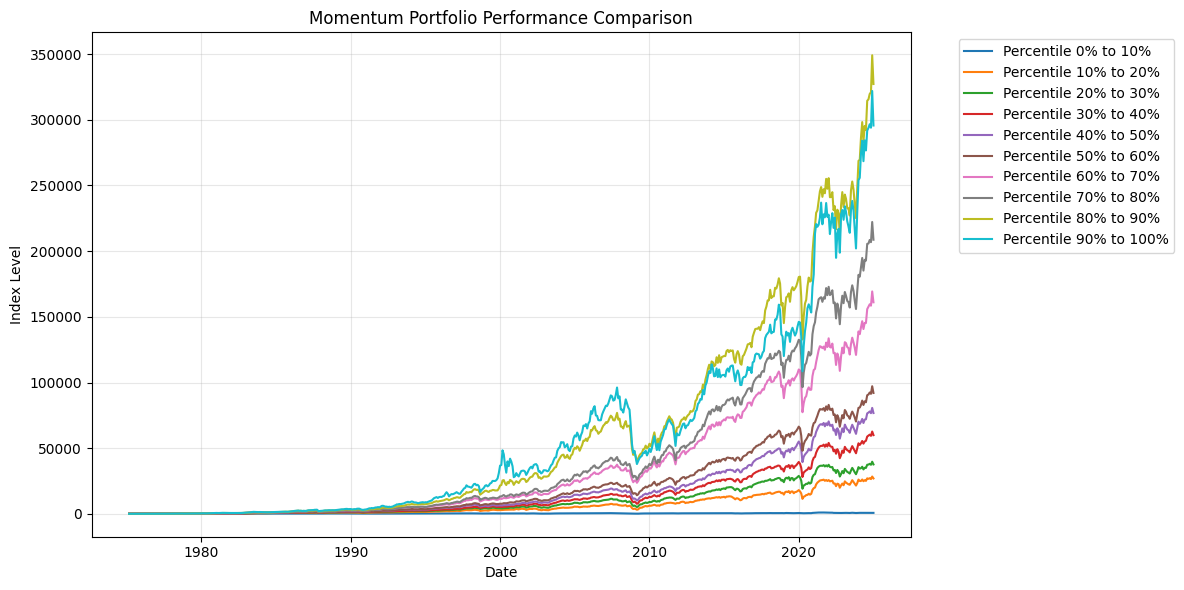

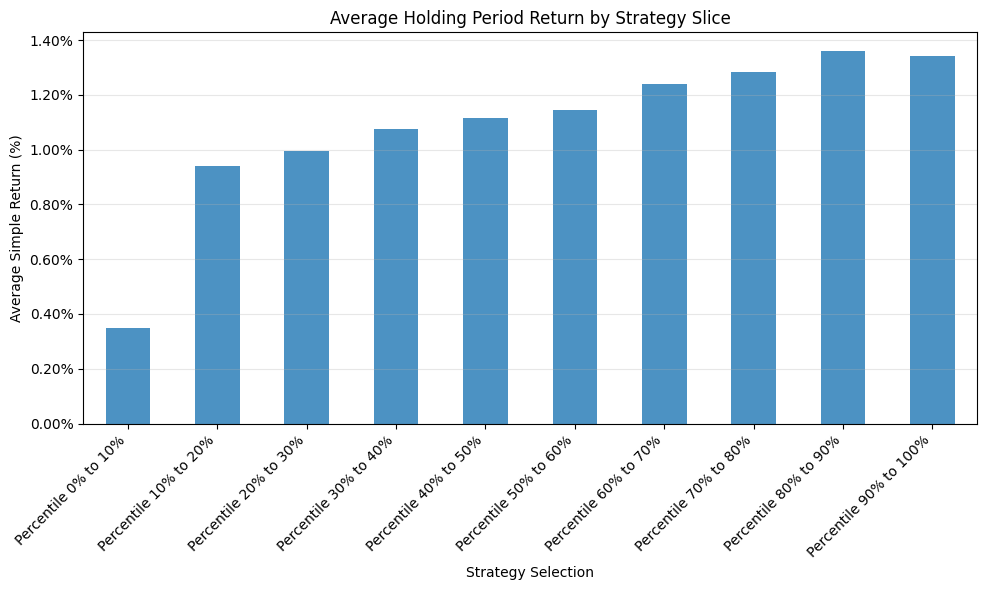

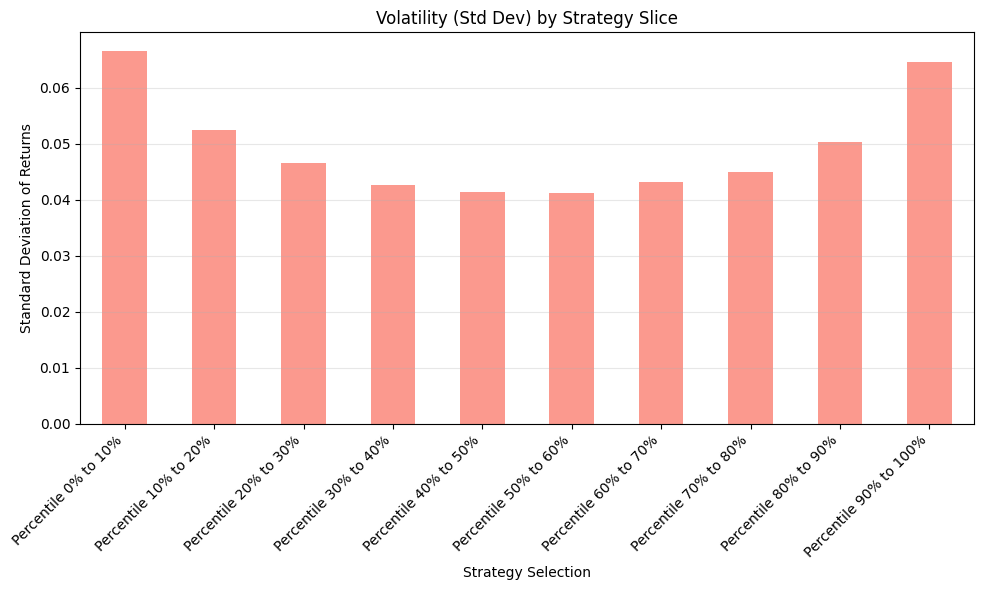


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%       4.27%          22.95%         0.19      -69.97%
 Percentile 10% to 20%      11.87%          18.01%         0.66      -58.23%
 Percentile 20% to 30%      12.62%          15.91%         0.79      -54.39%
 Percentile 30% to 40%      13.67%          14.63%         0.93      -49.47%
 Percentile 40% to 50%      14.24%          14.15%         1.01      -47.28%
 Percentile 50% to 60%      14.65%          14.02%         1.04      -40.10%
 Percentile 60% to 70%      15.94%          14.65%         1.09      -36.76%
 Percentile 70% to 80%      16.55%          15.34%         1.08      -39.71%
 Percentile 80% to 90%      17.60%          17.16%         1.03      -48.10%
Percentile 90% to 100%      17.36%          22.11%         0.79      -60.52%
---------------------------------------------


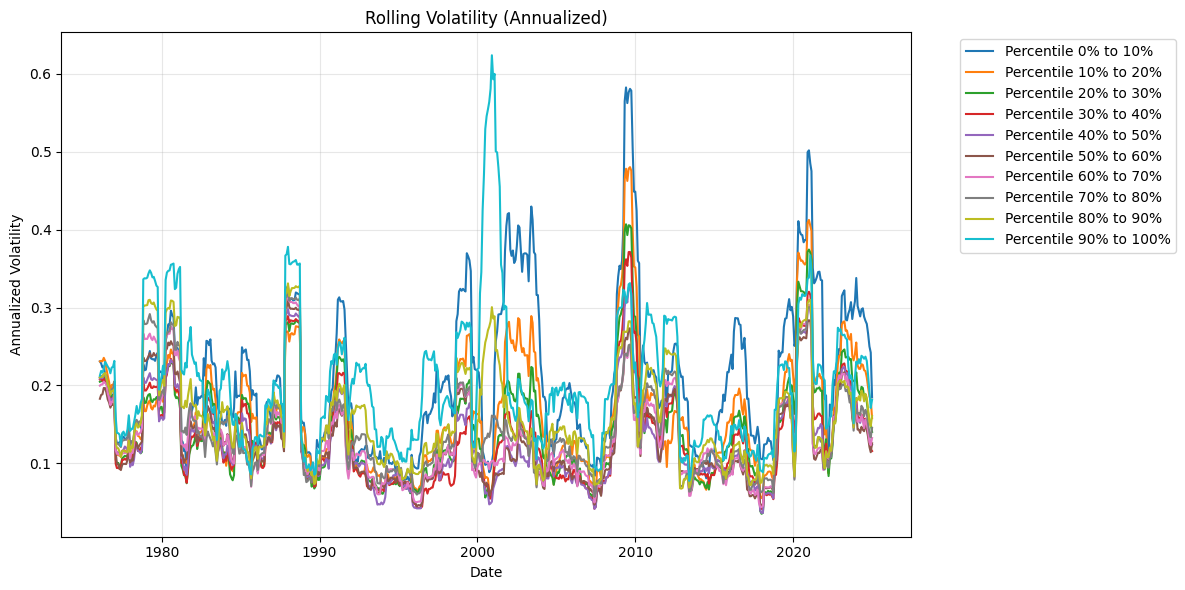

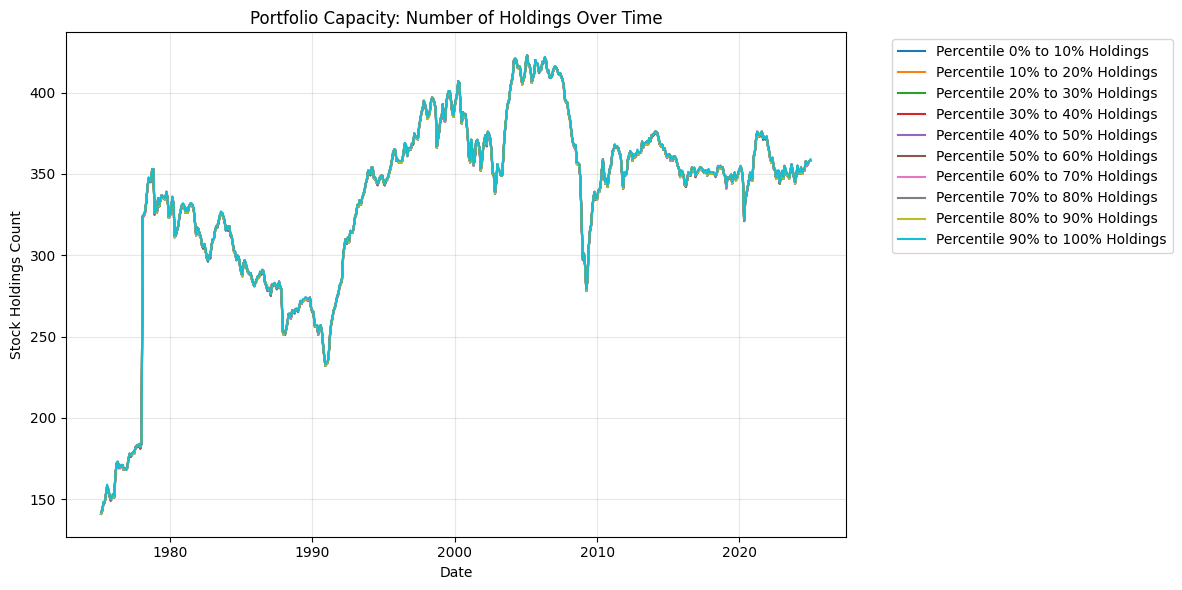

In [9]:
# 1. nittialize the class

Portfolio = MomentumPortfolio(START_DATE_LISTED, 
                                MIN_AVG_LISTED_PRICE, 
                                START_TIME, 
                                AGREGATION_PREIOD_OF_RETURNS, 
                                CLIP_EXTREME_RETURNS, 
                                PERCENTILES, 
                                LOOKBACK_PERIOD, 
                                LAST_PERIODS_TO_IGNORE, 
                                INVESTABLE_BIRTH_PERIODS,
                                MIN_INCLUDE_PRICE,
                                )


## Since the year 2000

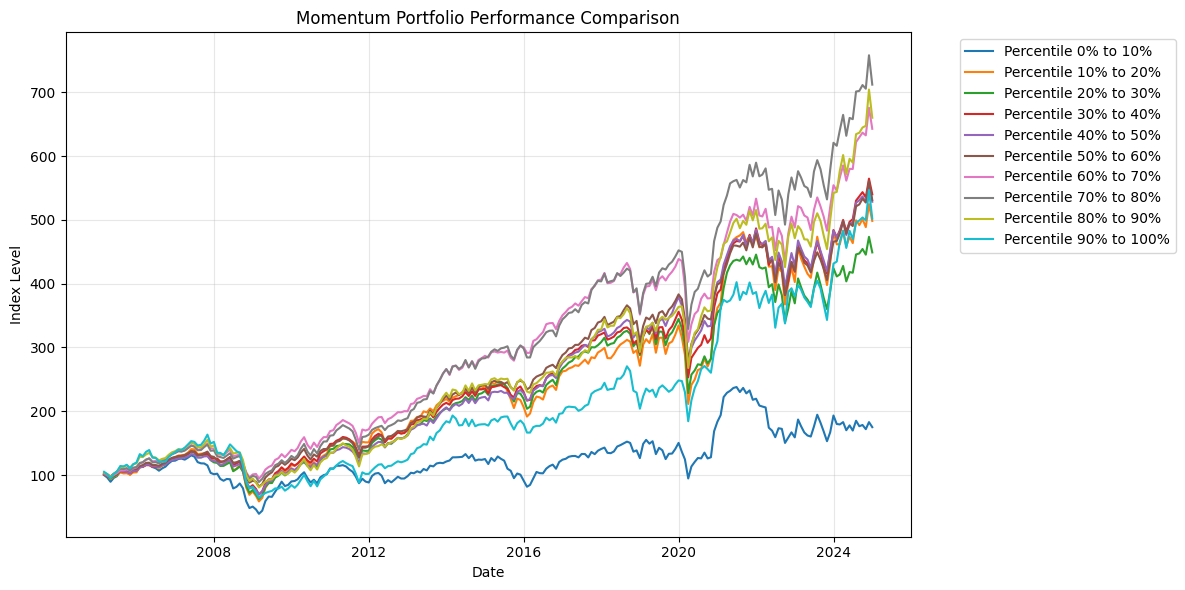

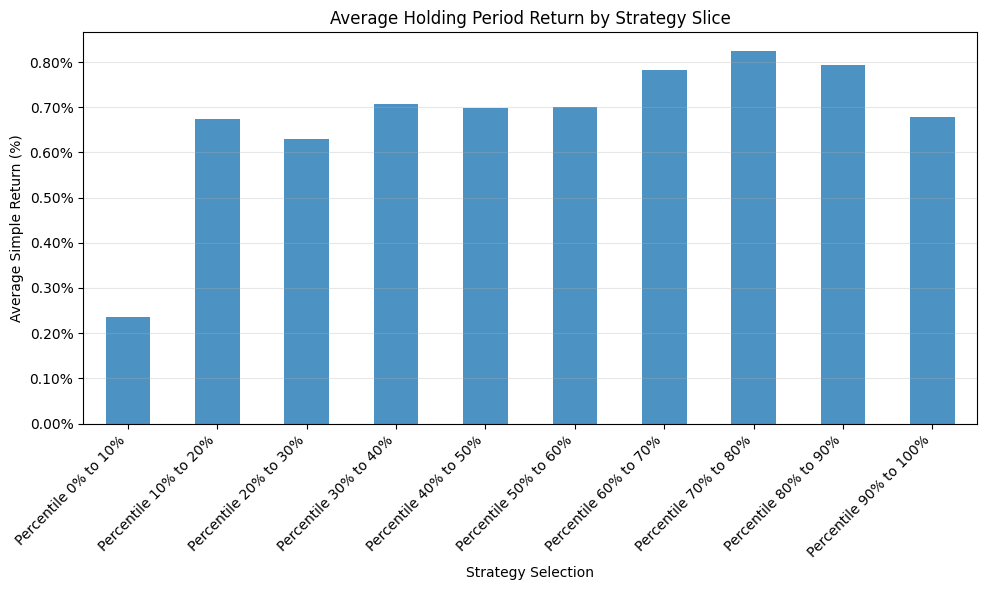

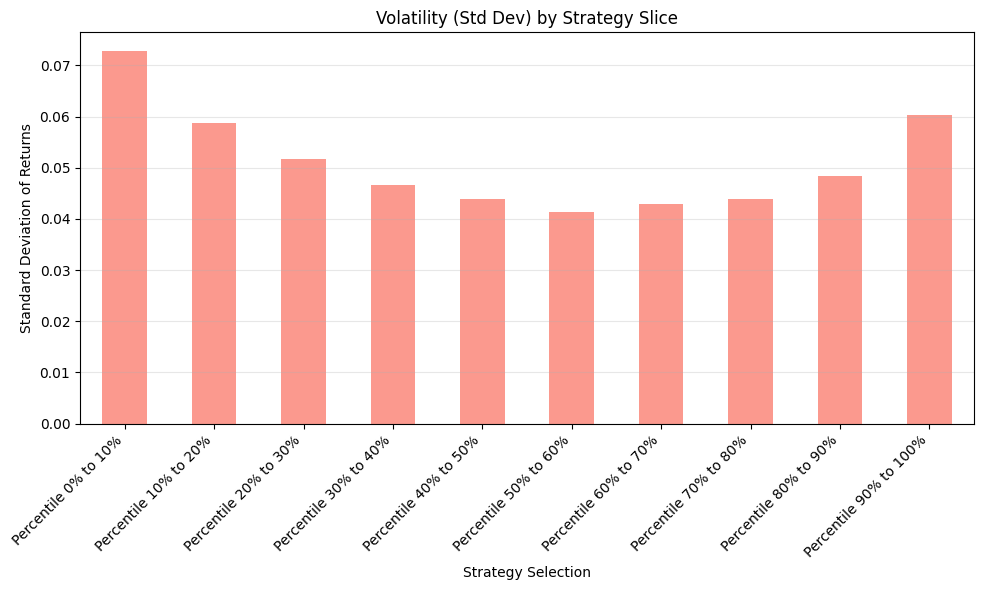


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%       2.85%          25.35%         0.11      -69.97%
 Percentile 10% to 20%       8.40%          20.07%         0.42      -58.23%
 Percentile 20% to 30%       7.83%          17.65%         0.44      -54.39%
 Percentile 30% to 40%       8.84%          15.95%         0.55      -49.47%
 Percentile 40% to 50%       8.72%          14.98%         0.58      -47.28%
 Percentile 50% to 60%       8.74%          14.15%         0.62      -40.10%
 Percentile 60% to 70%       9.79%          14.64%         0.67      -36.76%
 Percentile 70% to 80%      10.36%          15.01%         0.69      -39.71%
 Percentile 80% to 90%       9.94%          16.54%         0.60      -48.10%
Percentile 90% to 100%       8.44%          20.65%         0.41      -60.52%
---------------------------------------------


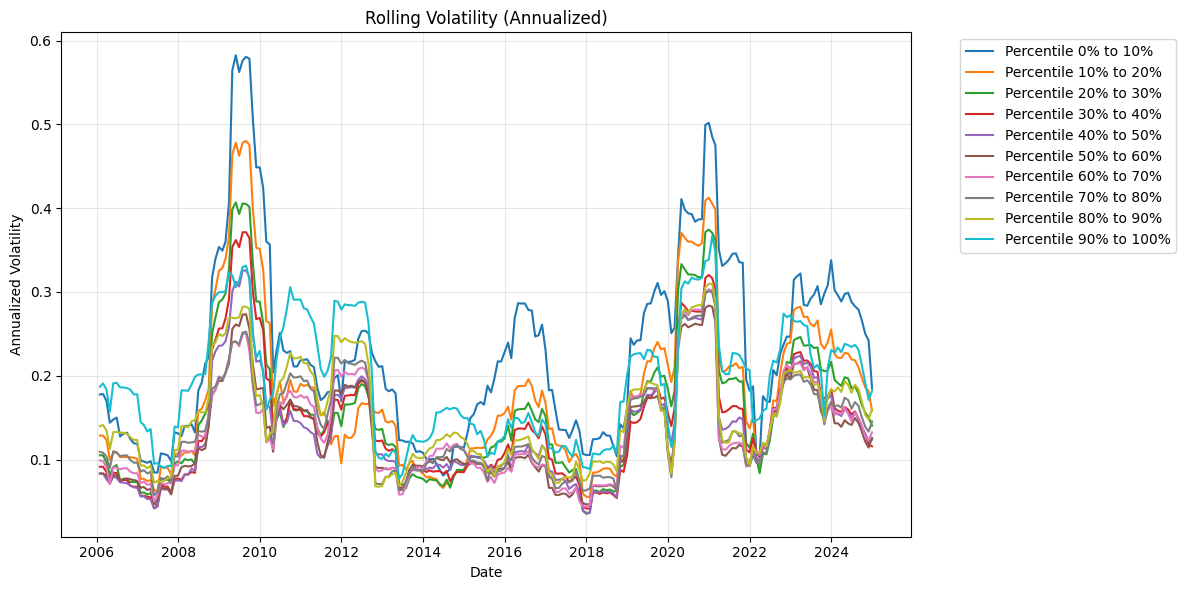

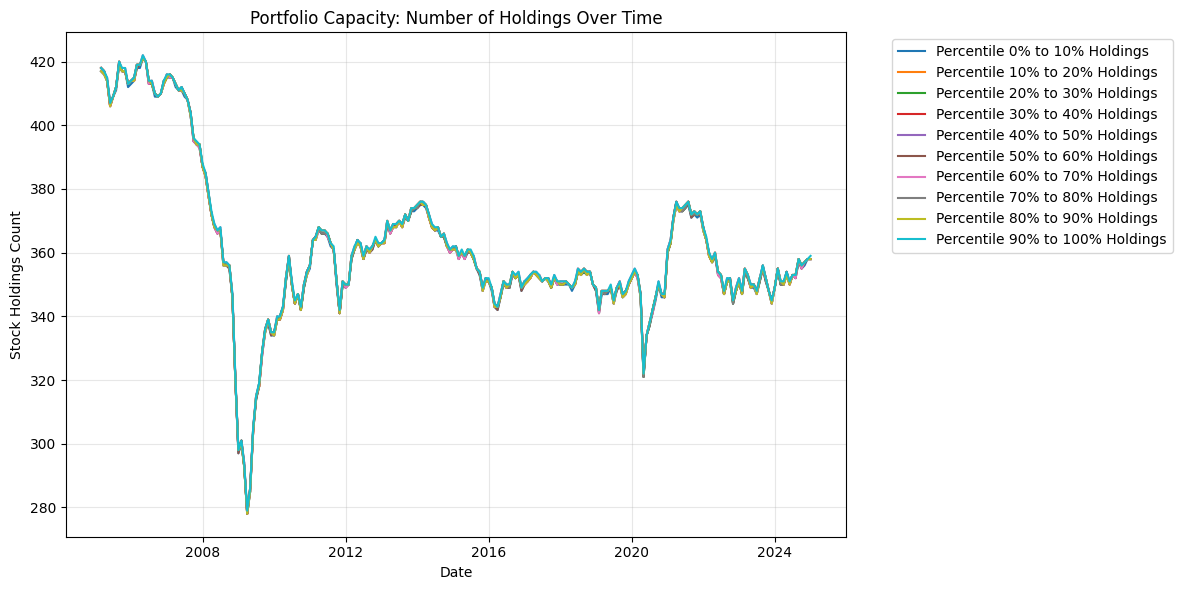

In [10]:
START_TIME = "2000-01-01"
# 1. nittialize the class

Portfolio = MomentumPortfolio(START_DATE_LISTED, 
                                MIN_AVG_LISTED_PRICE, 
                                START_TIME, 
                                AGREGATION_PREIOD_OF_RETURNS, 
                                CLIP_EXTREME_RETURNS, 
                                PERCENTILES, 
                                LOOKBACK_PERIOD, 
                                LAST_PERIODS_TO_IGNORE, 
                                INVESTABLE_BIRTH_PERIODS,
                                MIN_INCLUDE_PRICE,
                                )

## Since the year 2015

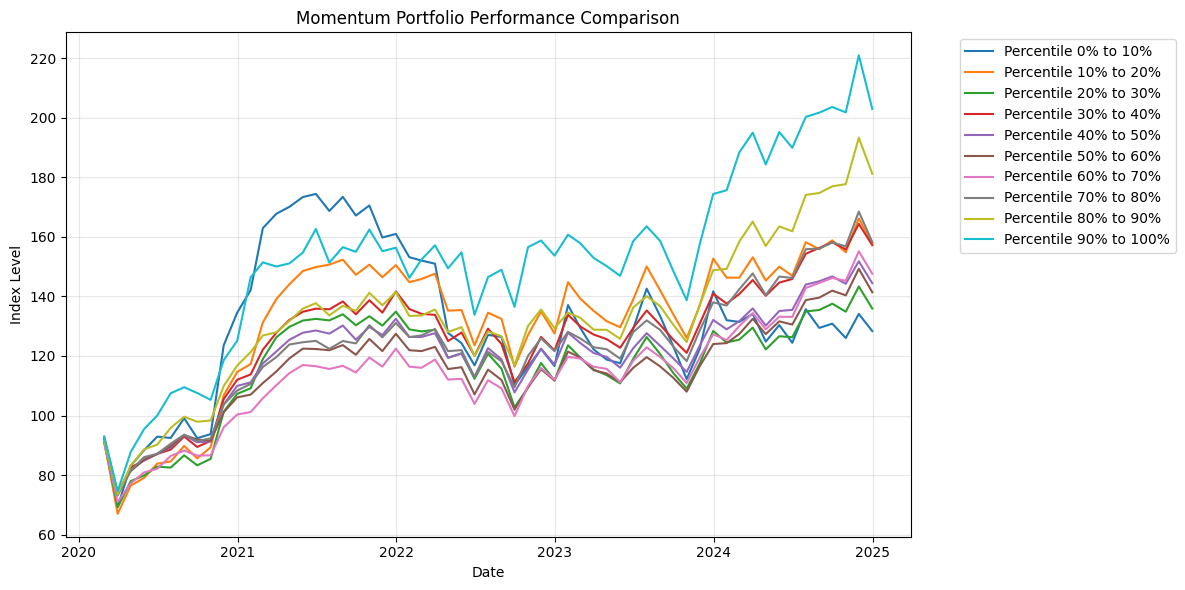

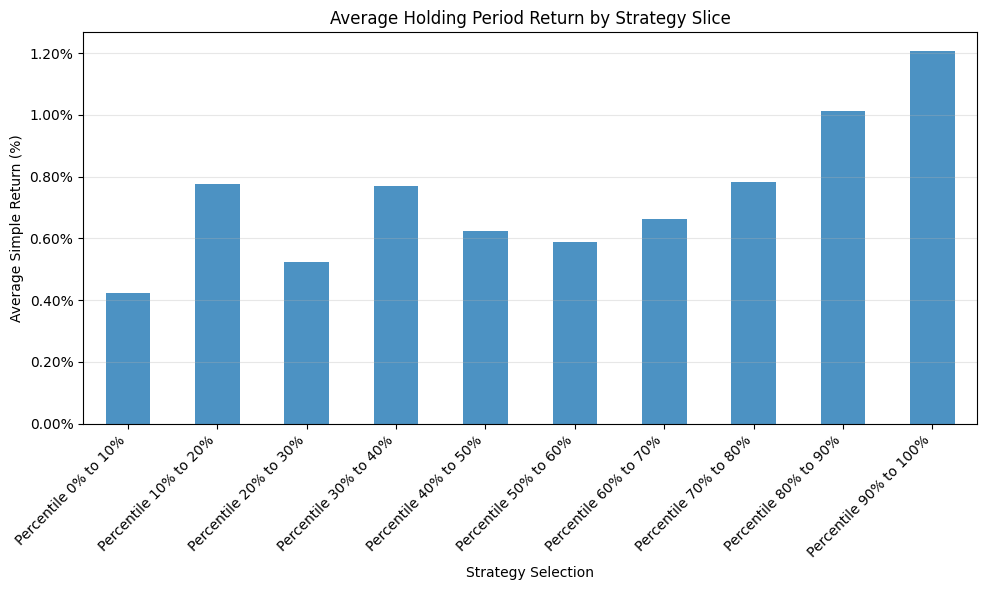

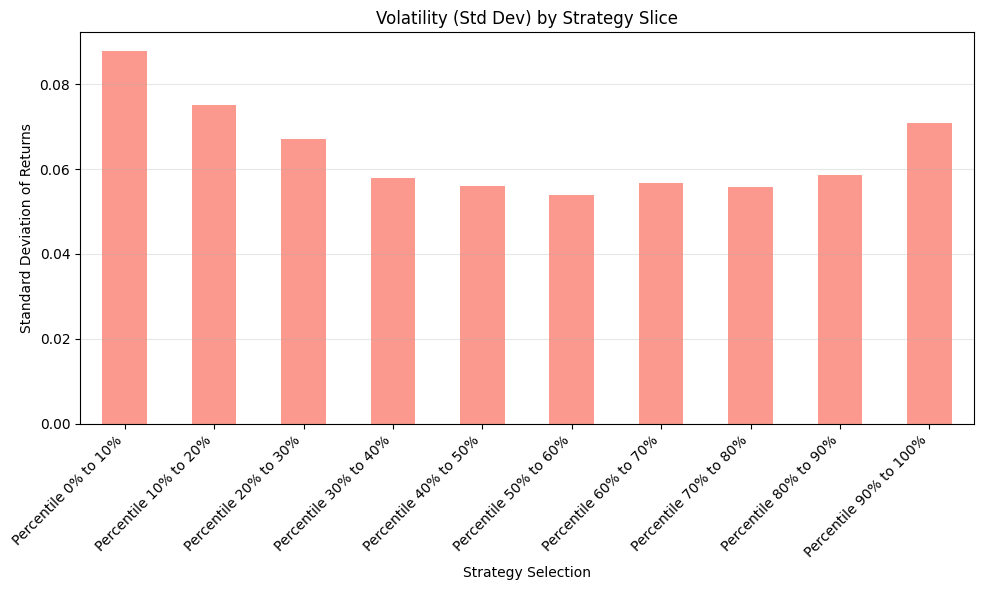


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%       5.21%          30.99%         0.17      -36.81%
 Percentile 10% to 20%       9.73%          25.45%         0.38      -26.66%
 Percentile 20% to 30%       6.44%          22.71%         0.28      -24.48%
 Percentile 30% to 40%       9.64%          19.82%         0.49      -21.51%
 Percentile 40% to 50%       7.76%          19.04%         0.41      -20.08%
 Percentile 50% to 60%       7.30%          18.23%         0.40      -20.01%
 Percentile 60% to 70%       8.24%          19.09%         0.43      -21.81%
 Percentile 70% to 80%       9.79%          18.99%         0.52      -19.92%
 Percentile 80% to 90%      12.85%          20.06%         0.64      -19.74%
Percentile 90% to 100%      15.48%          24.67%         0.63      -19.81%
---------------------------------------------


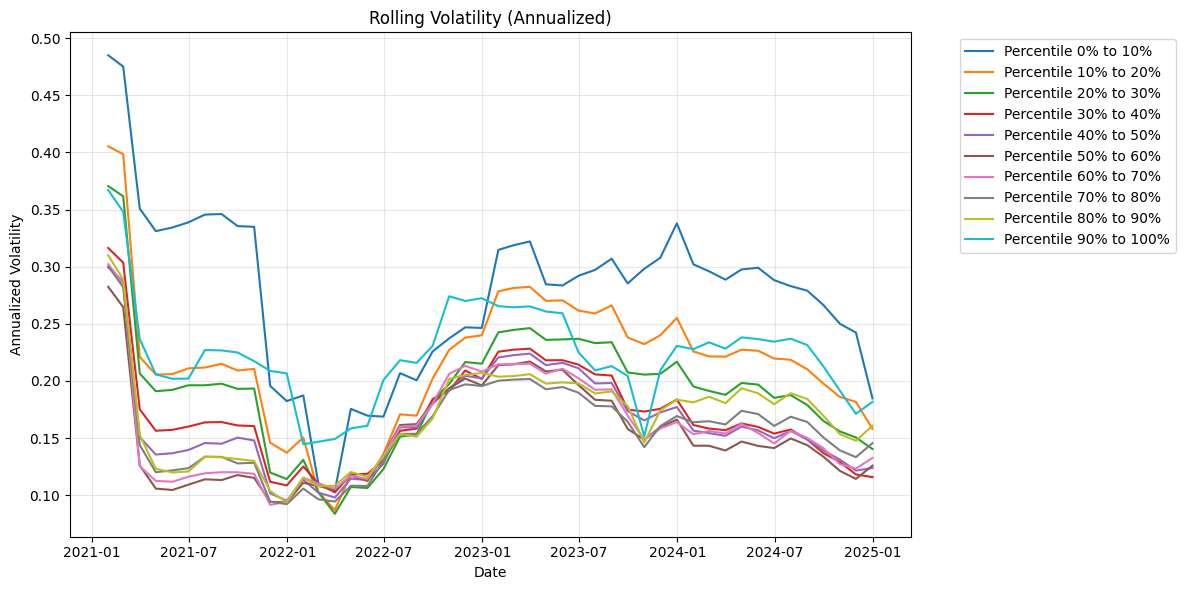

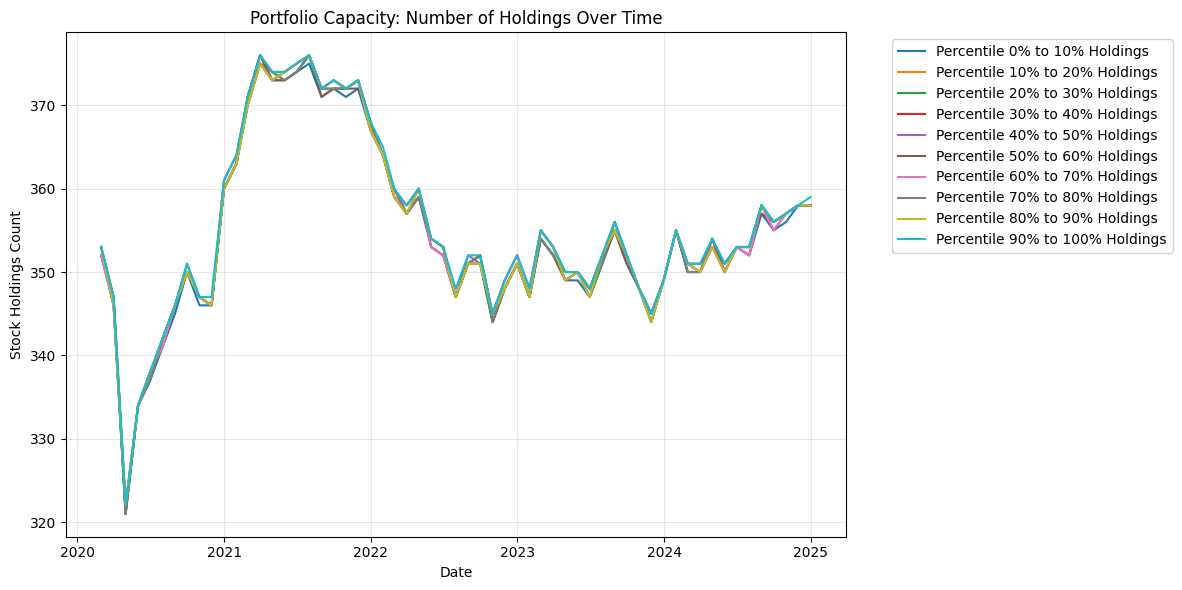

In [11]:
START_TIME = "2015-01-01"
# 1. nittialize the class

Portfolio = MomentumPortfolio(START_DATE_LISTED, 
                                MIN_AVG_LISTED_PRICE, 
                                START_TIME, 
                                AGREGATION_PREIOD_OF_RETURNS, 
                                CLIP_EXTREME_RETURNS, 
                                PERCENTILES, 
                                LOOKBACK_PERIOD, 
                                LAST_PERIODS_TO_IGNORE, 
                                INVESTABLE_BIRTH_PERIODS,
                                MIN_INCLUDE_PRICE,
                                )

## Very High momentum portfolios

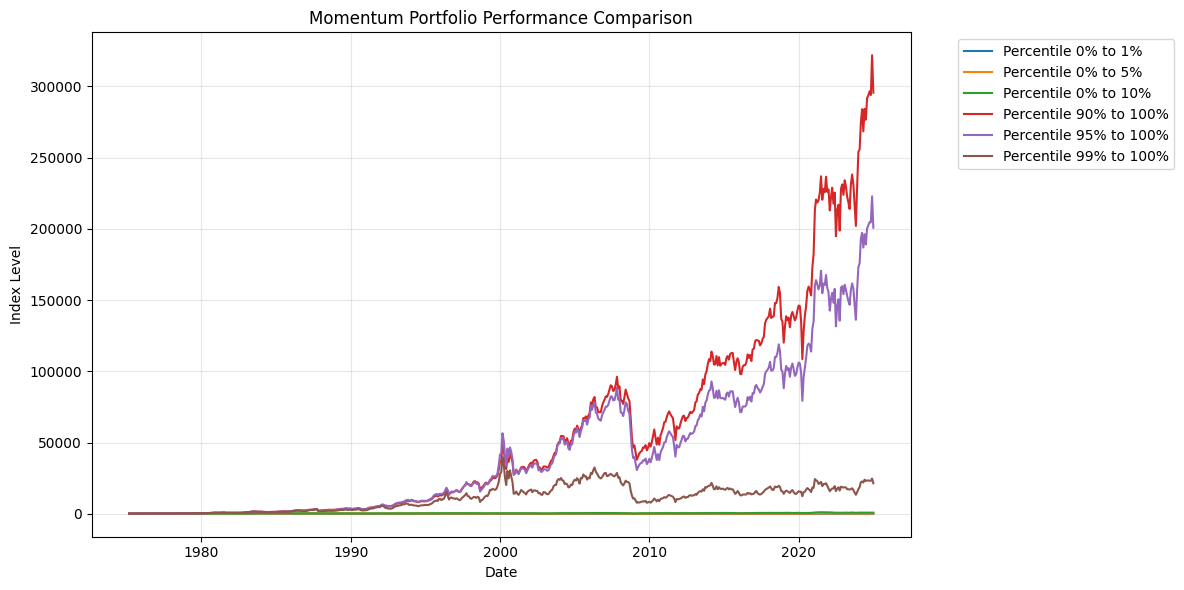

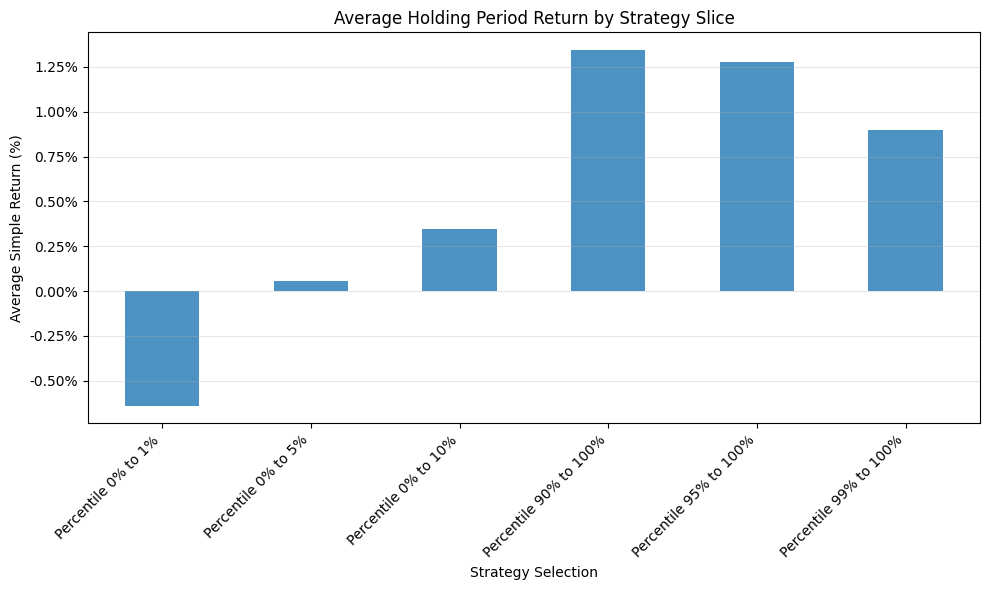

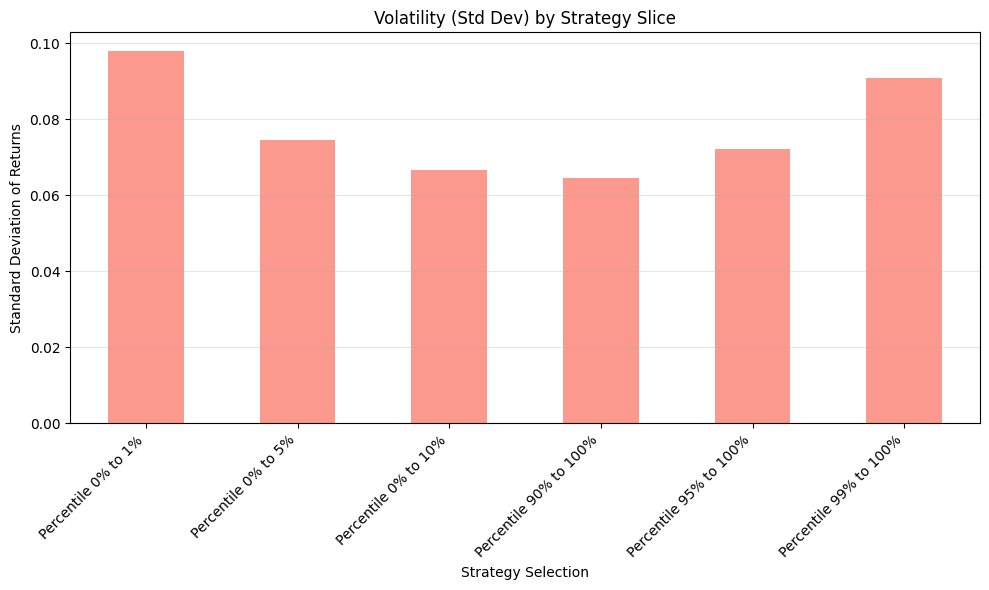


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
   Percentile 0% to 1%      -7.40%          35.74%        -0.21      -98.92%
   Percentile 0% to 5%       0.69%          25.79%         0.03      -82.65%
  Percentile 0% to 10%       4.27%          22.95%         0.19      -69.97%
Percentile 90% to 100%      17.36%          22.11%         0.79      -60.52%
Percentile 95% to 100%      16.46%          24.68%         0.67      -65.29%
Percentile 99% to 100%      11.35%          31.09%         0.37      -80.55%
---------------------------------------------


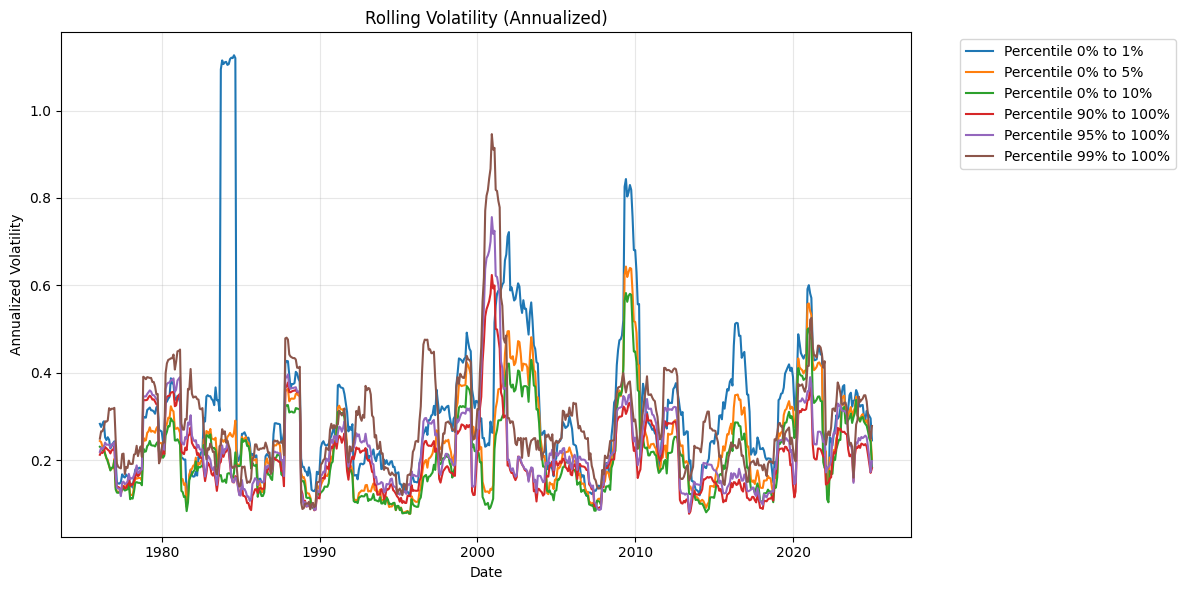

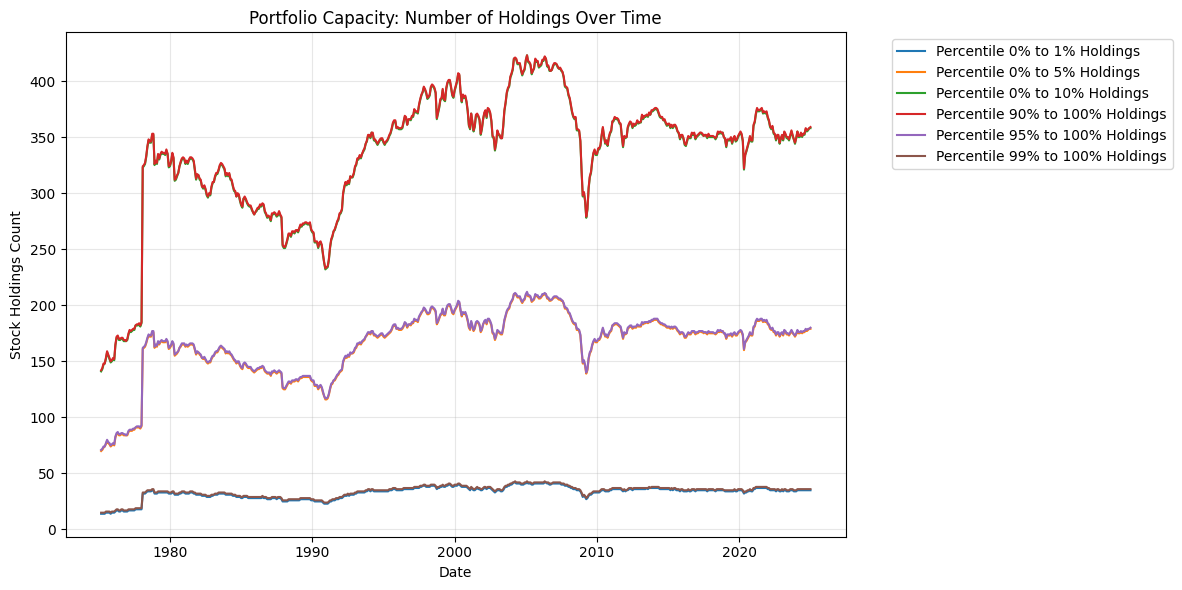

In [12]:
PERCENTILES = [
    (0,1), 
    (0,5), 
    (0,10),  
    (90,100), 
    (95,100), 
    (99,100)
]
START_TIME = "1970-01-01"
# 1. nittialize the class

Portfolio = MomentumPortfolio(START_DATE_LISTED, 
                                MIN_AVG_LISTED_PRICE, 
                                START_TIME, 
                                AGREGATION_PREIOD_OF_RETURNS, 
                                CLIP_EXTREME_RETURNS, 
                                PERCENTILES, 
                                LOOKBACK_PERIOD, 
                                LAST_PERIODS_TO_IGNORE, 
                                INVESTABLE_BIRTH_PERIODS,
                                MIN_INCLUDE_PRICE,
                                )

In [13]:
# You cna use the Portfolio object to see what is going on in memory betwen steps
#print("Min log return:", np.nanmin(Portfolio.data.values))
#print("Max log return:", np.nanmax(Portfolio.data.values))

In [14]:
#print(Portfolio.percentile_results["Percentile 90% to 100%"])
#Portfolio.data.describe()

In [15]:
# dealocate the previous portfolio to cleanup ram
#del Portfolio

# Inherited Long/Short Momentum Portfolio Class Usage

We can Compute Individual Porfolios and use them to do follow up analysis

Loading library list...
Done
Saved 18958 rows for benchmark CRSP_VWRETD
--- Statistics vs Benchmark ---
Beta: -0.2195
Correlation: -0.2035


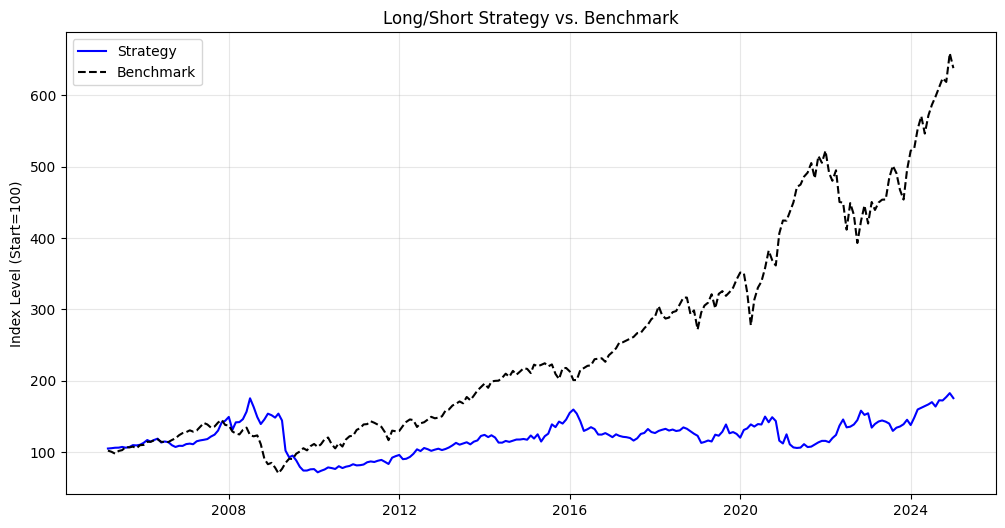

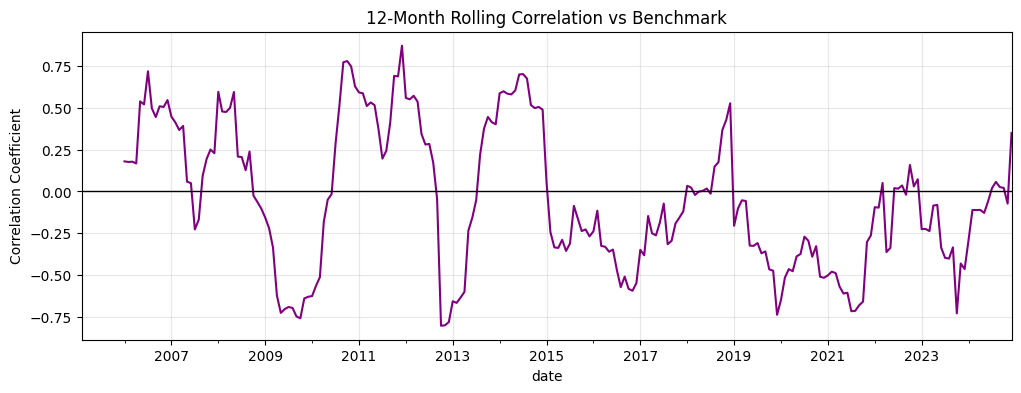

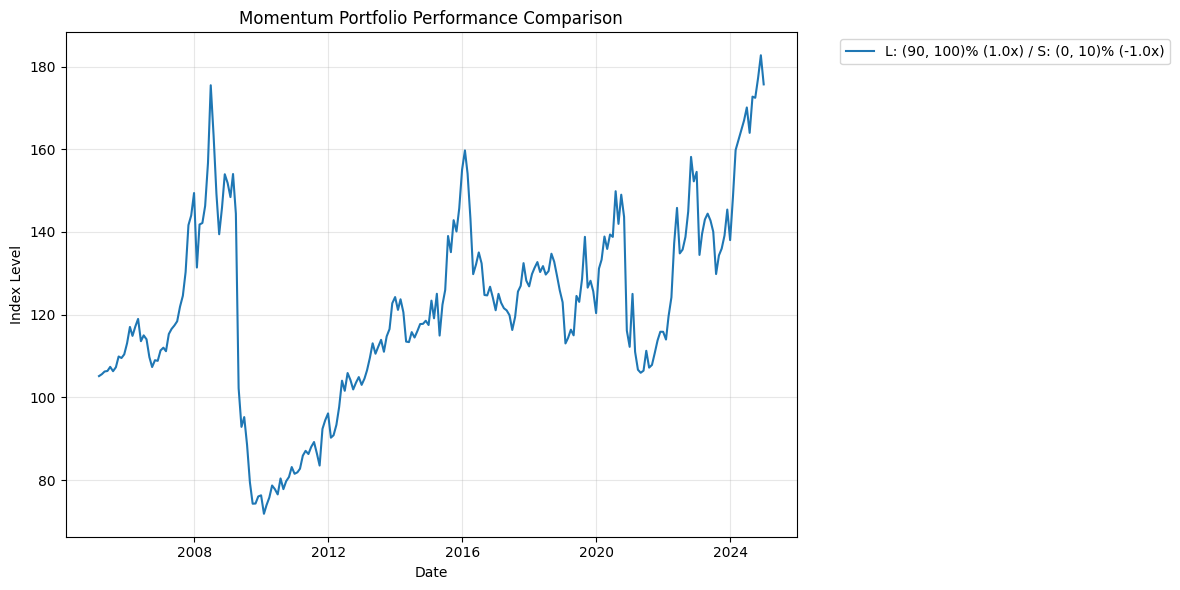

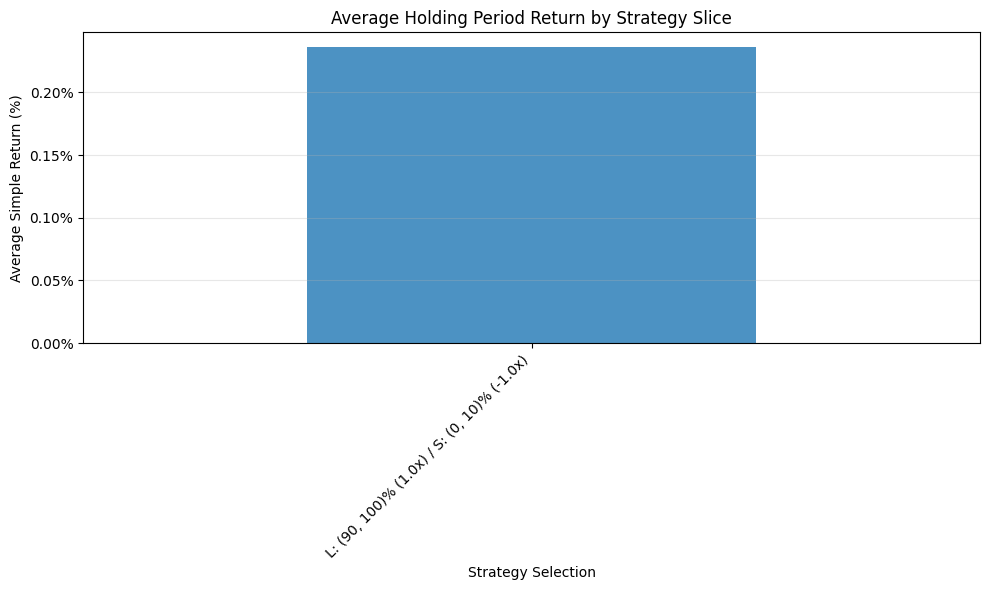

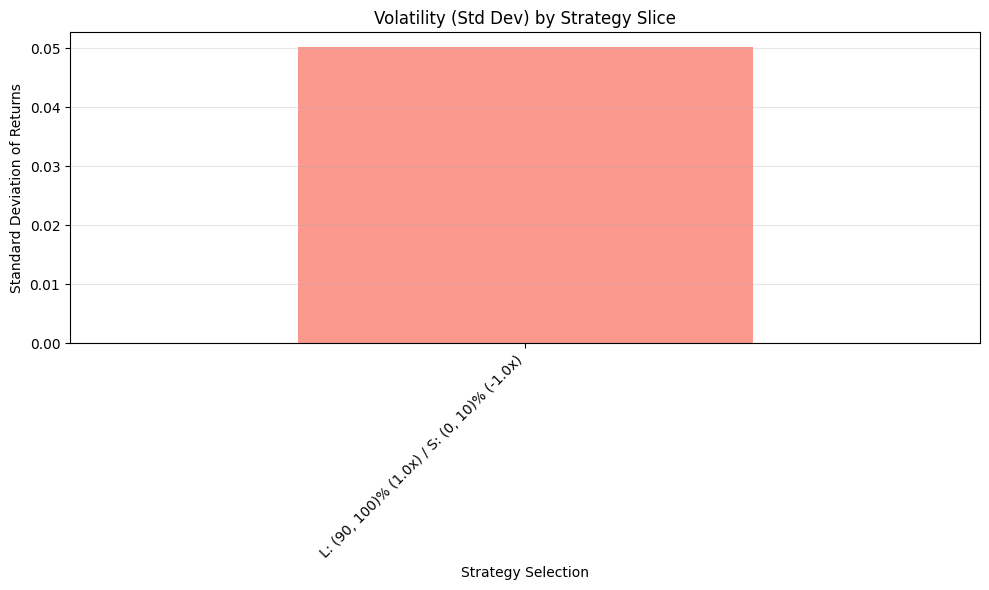


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-1.0x)       2.87%          16.71%         0.17      -59.06%
---------------------------------------------


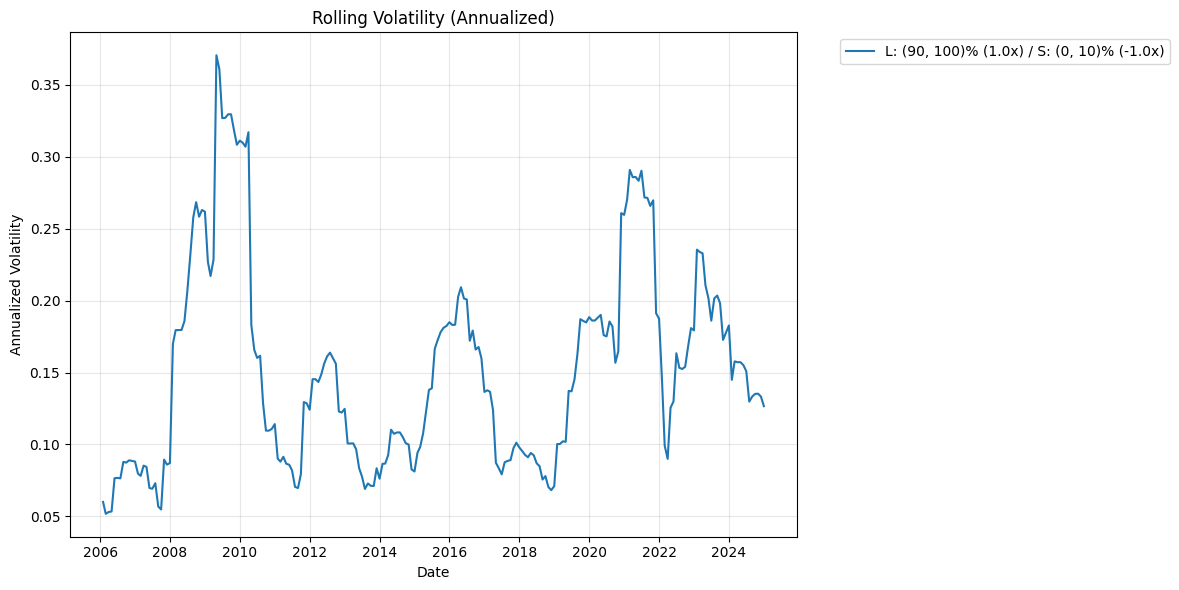


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   6.81%
Beta:               -0.22
Information Ratio:  -0.27
Tracking Error:     25.00%
--------------------------------------------------
Strategy Ann. Ret:  4.38%
Benchmark Ann. Ret: 11.08%
--------------------------------------------------


In [16]:
"""
Long Short Portfolio
50% Long top 10% 
50% Short bottom 10%
"""

download_crsp_benchmark_to_duckdb("CRSP_VWRETD")
# create an instance of the stock portfolio
long_short_Portfolio = LongShortMomentumPortfolio(
    START_DATE_LISTED="2020-01-01",
    MIN_AVG_LISTED_PRICE=5.0,
    START_TIME="2000-01-01",
    AGREGATION_PREIOD_OF_RETURNS="ME",
    CLIP_EXTREME_RETURNS=True,
    LOOKBACK_PERIOD=12,
    LAST_PERIODS_TO_IGNORE=1,
    INVESTABLE_BIRTH_PERIODS=60,
    MIN_INCLUDE_PRICE=5.0,
    LONG_PERCENTILE=(90, 100),
    SHORT_PERCENTILE=(0, 10),
    LONG_WEIGHT=1.0,
    SHORT_WEIGHT=-1.0,
    BENCHMARK="CRSP_VWRETD",   
)

Requesting SPY... [✓] Success
Saved 8322 rows for benchmark SPY
--- Statistics vs Benchmark ---
Beta: -0.2130
Correlation: -0.1911


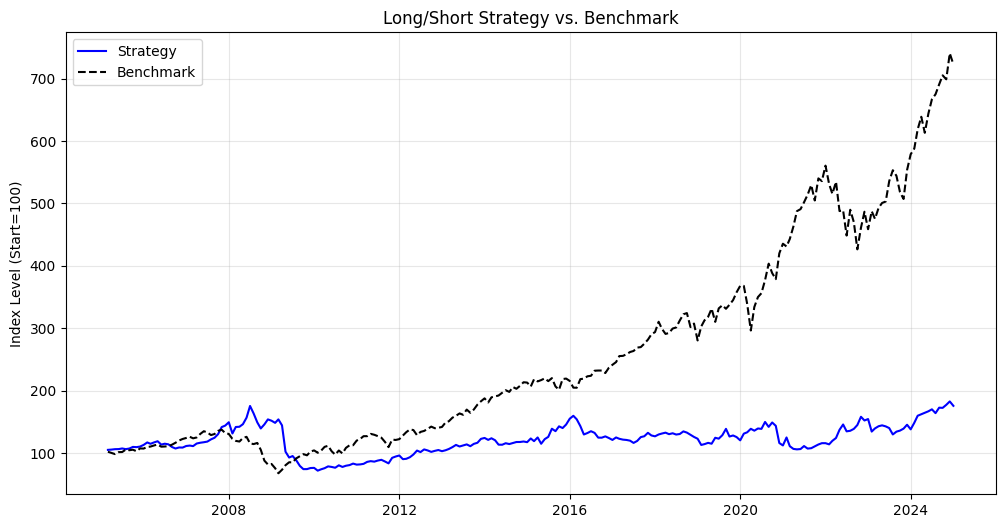

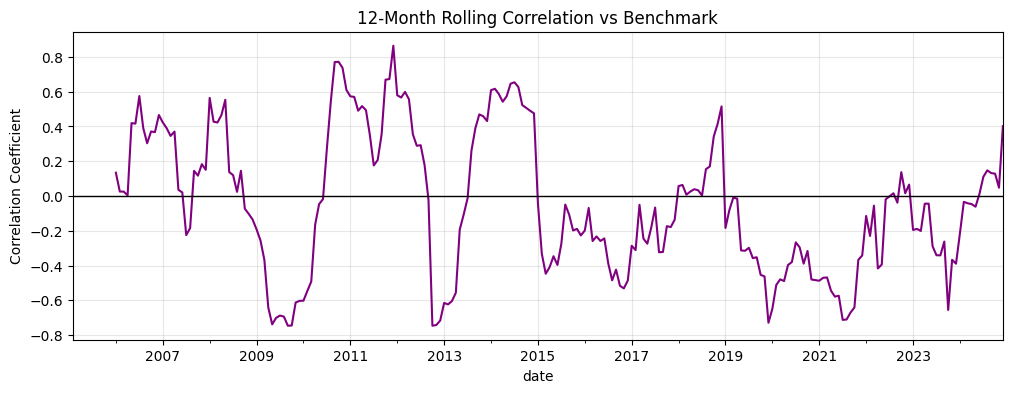

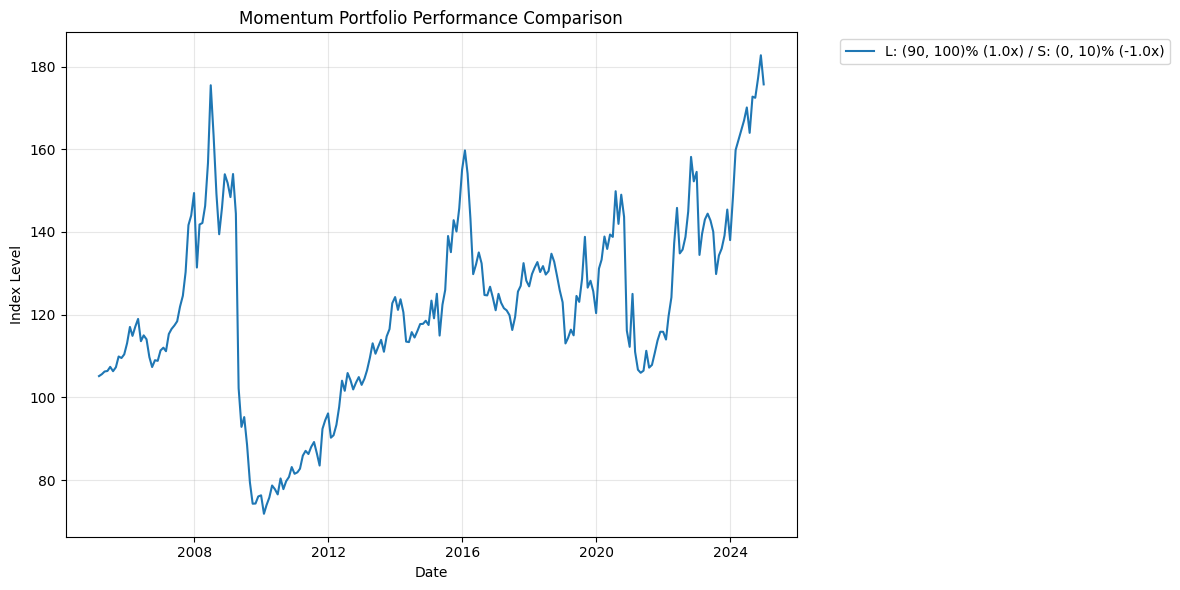

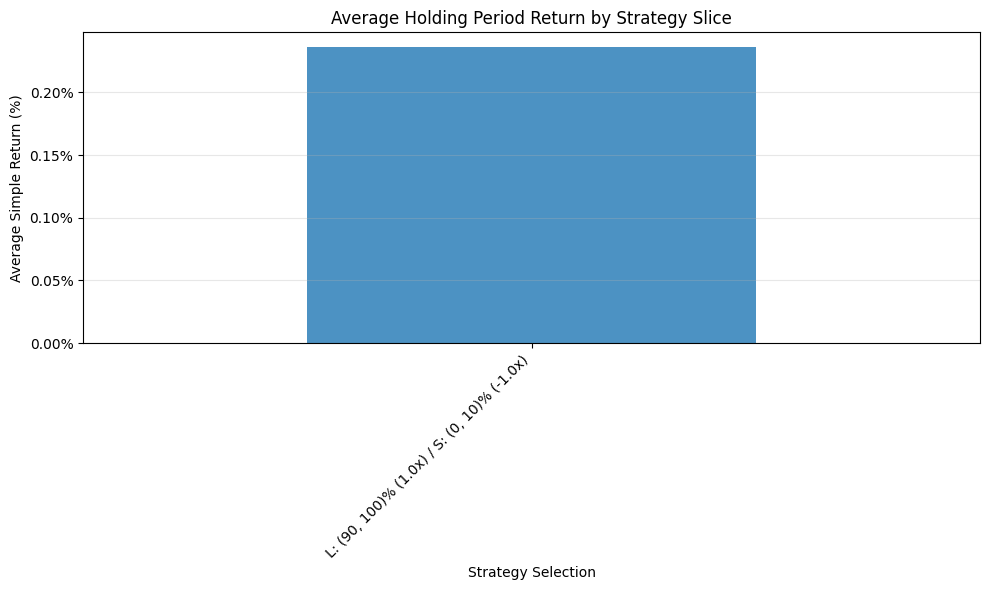

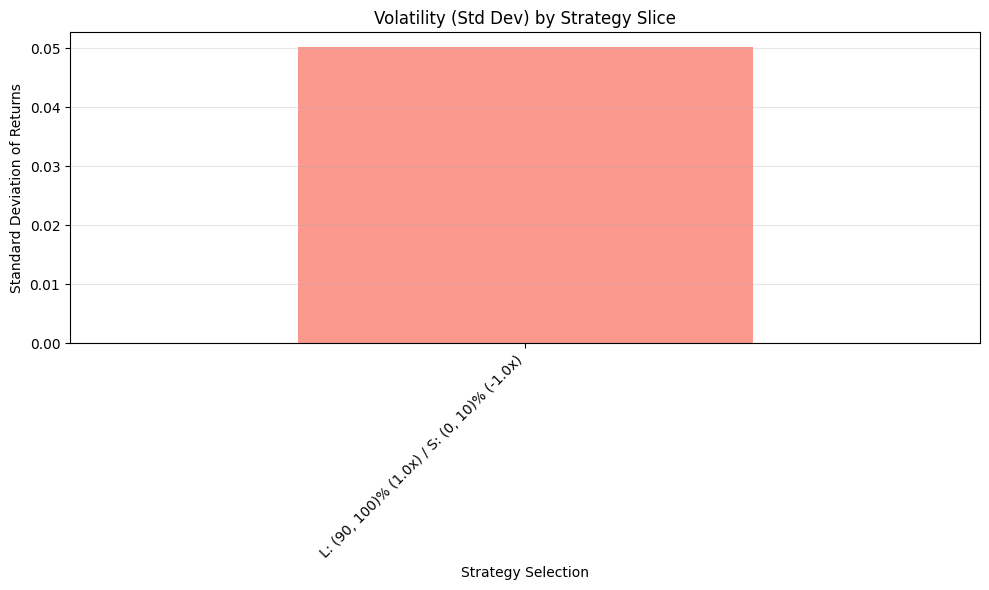


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-1.0x)       2.87%          16.71%         0.17      -59.06%
---------------------------------------------


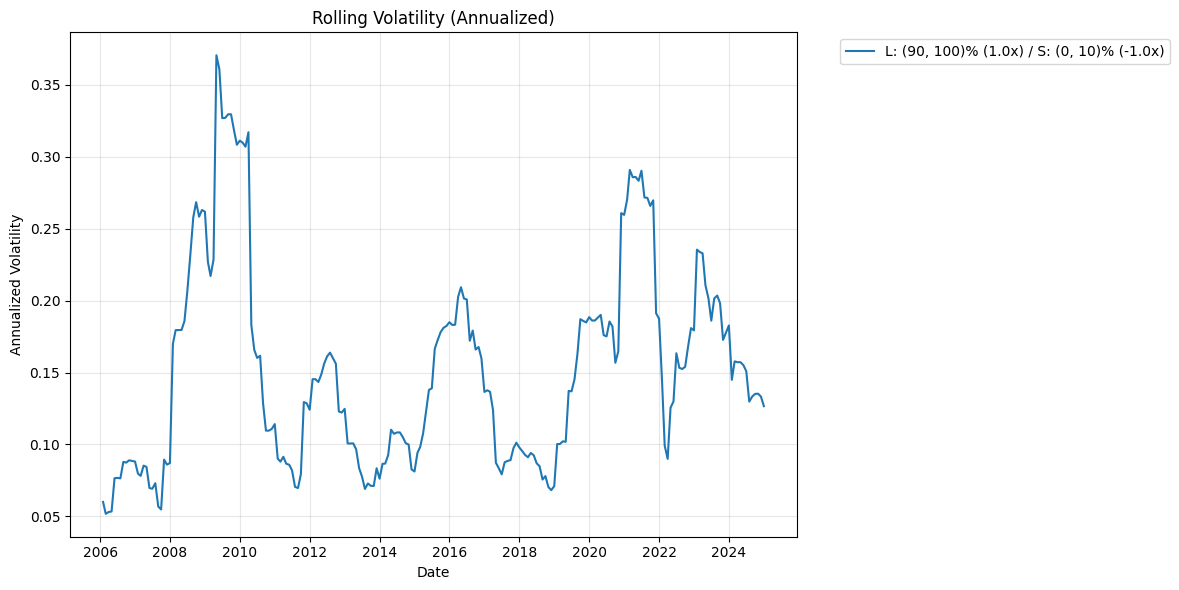


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   6.87%
Beta:               -0.21
Information Ratio:  -0.30
Tracking Error:     24.50%
--------------------------------------------------
Strategy Ann. Ret:  4.38%
Benchmark Ann. Ret: 11.69%
--------------------------------------------------


In [17]:
download_benchmark_to_duckdb_yfinance("SPY")
long_short_Portfolio = LongShortMomentumPortfolio(
    START_DATE_LISTED="2020-01-01",
    MIN_AVG_LISTED_PRICE=5.0,
    START_TIME="2000-01-01",
    AGREGATION_PREIOD_OF_RETURNS="ME",
    CLIP_EXTREME_RETURNS=True,
    LOOKBACK_PERIOD=12,
    LAST_PERIODS_TO_IGNORE=1,
    INVESTABLE_BIRTH_PERIODS=60,
    MIN_INCLUDE_PRICE=5.0,
    LONG_PERCENTILE=(90, 100),
    SHORT_PERCENTILE=(0, 10),
    LONG_WEIGHT=1.0,
    SHORT_WEIGHT=-1.0,
    BENCHMARK="SPY",   
)

--- Statistics vs Benchmark ---
Beta: 0.8808
Correlation: 0.7701


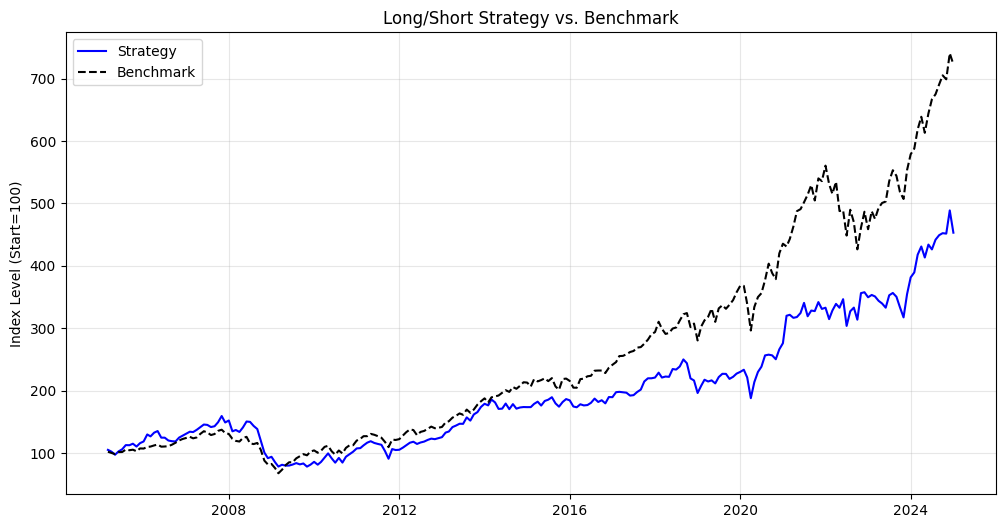

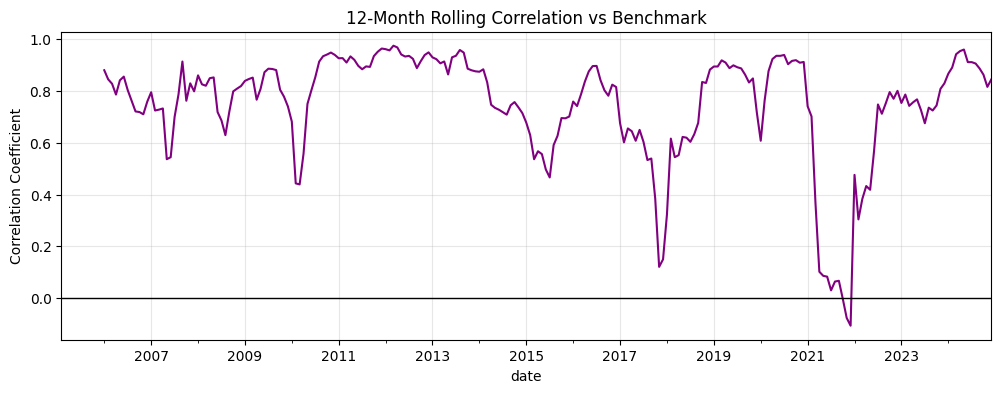

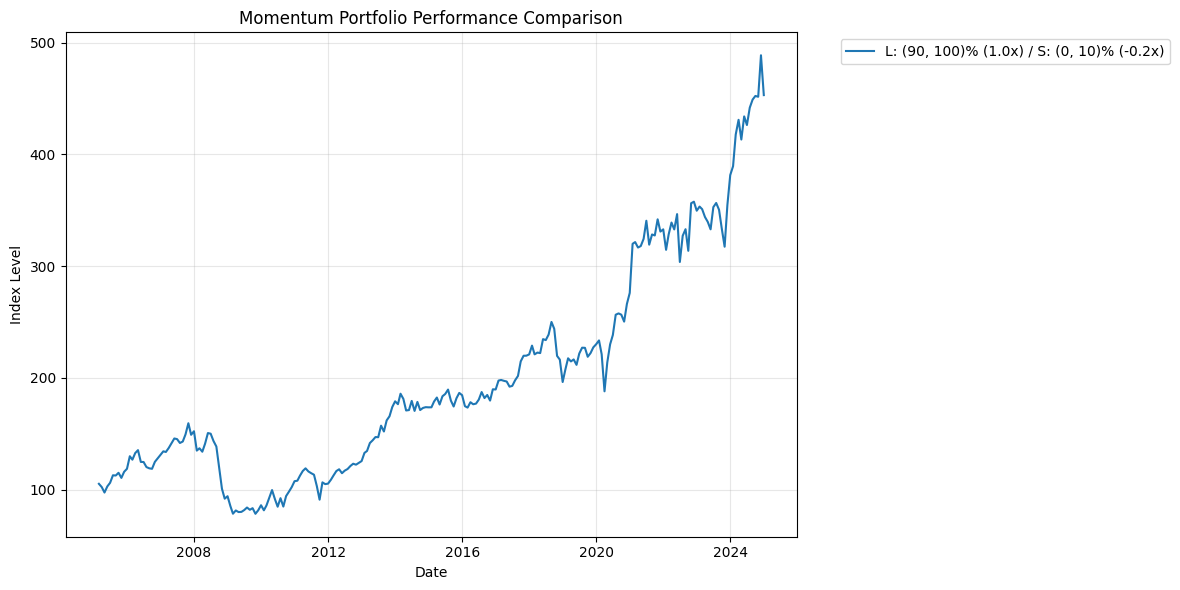

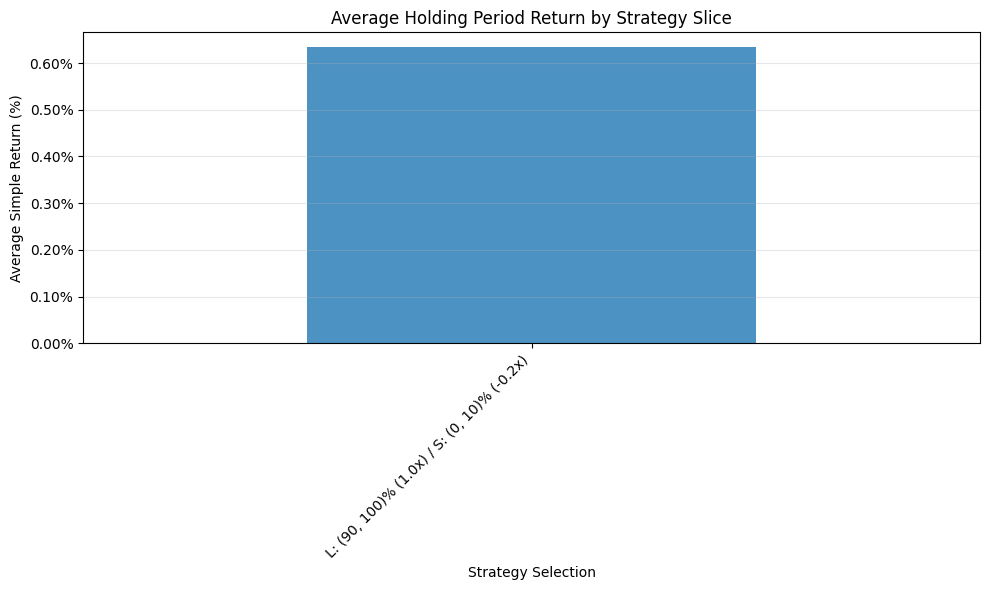

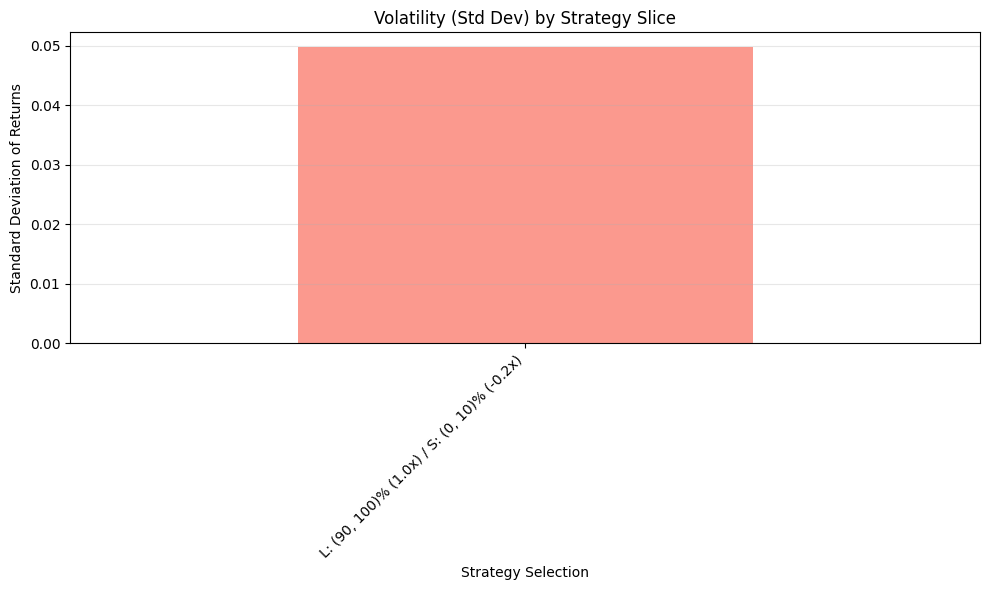


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-0.2x)       7.88%          17.16%         0.46      -50.87%
---------------------------------------------


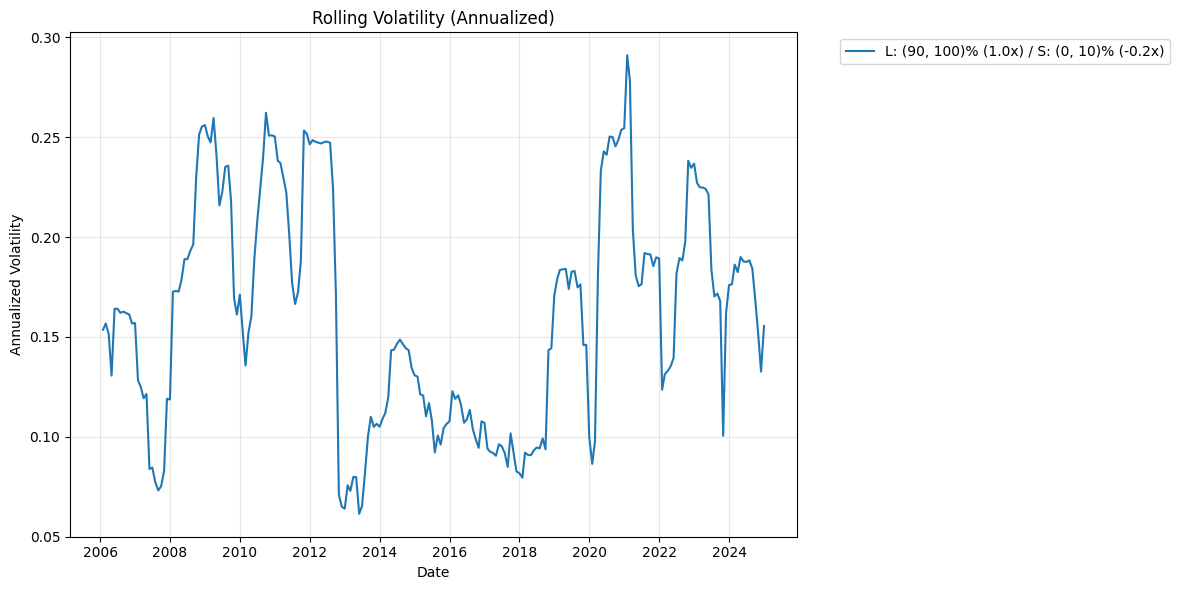


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   -0.82%
Beta:               0.88
Information Ratio:  -0.20
Tracking Error:     11.09%
--------------------------------------------------
Strategy Ann. Ret:  9.47%
Benchmark Ann. Ret: 11.69%
--------------------------------------------------


In [18]:
"""
Long Short Portfolio
80% Long top 10% 
20% Short bottom 10%
"""
long_short_Portfolio = LongShortMomentumPortfolio(
    START_DATE_LISTED="2020-01-01",
    MIN_AVG_LISTED_PRICE=5.0,
    START_TIME="2000-01-01",
    AGREGATION_PREIOD_OF_RETURNS="ME",
    CLIP_EXTREME_RETURNS=True,
    LOOKBACK_PERIOD=12,
    LAST_PERIODS_TO_IGNORE=1,
    INVESTABLE_BIRTH_PERIODS=60,
    MIN_INCLUDE_PRICE=5.0,
    LONG_PERCENTILE=(90, 100),
    SHORT_PERCENTILE=(0, 10),
    LONG_WEIGHT=1.0,
    SHORT_WEIGHT=-0.2,
    BENCHMARK="SPY",   
)

--- Statistics vs Benchmark ---
Beta: 1.1543
Correlation: 0.8383


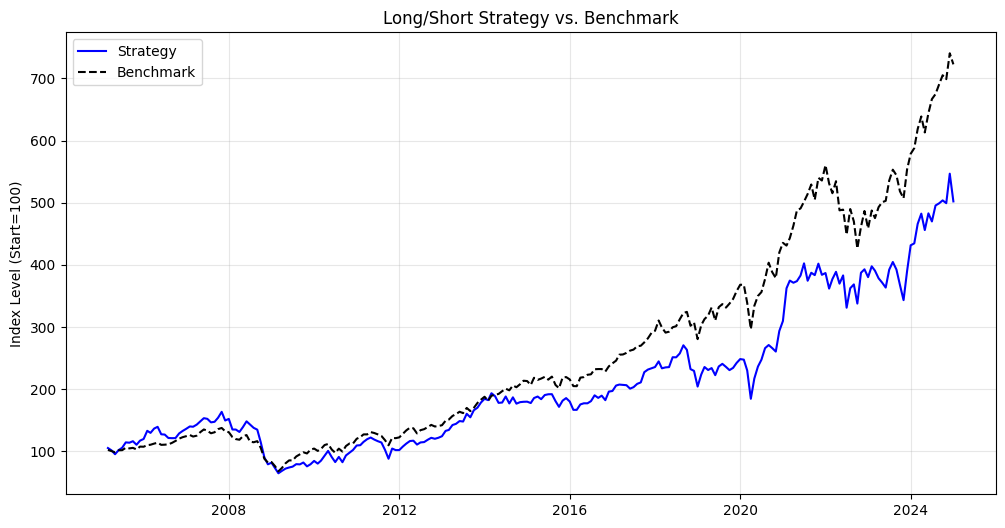

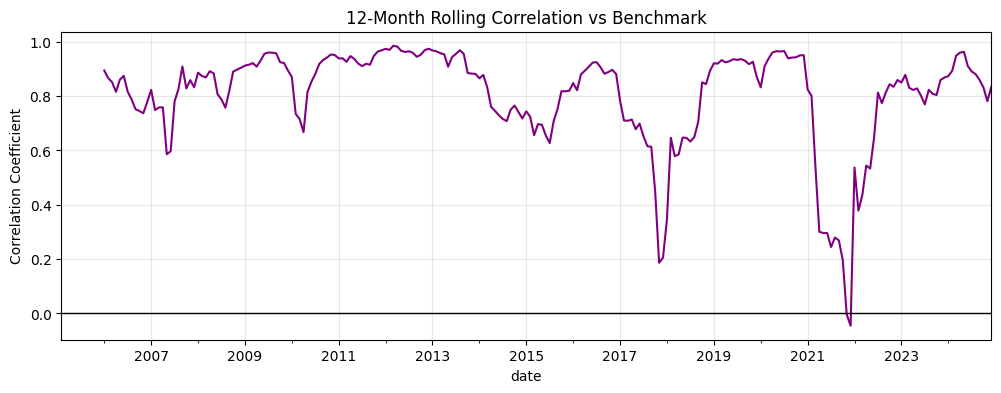

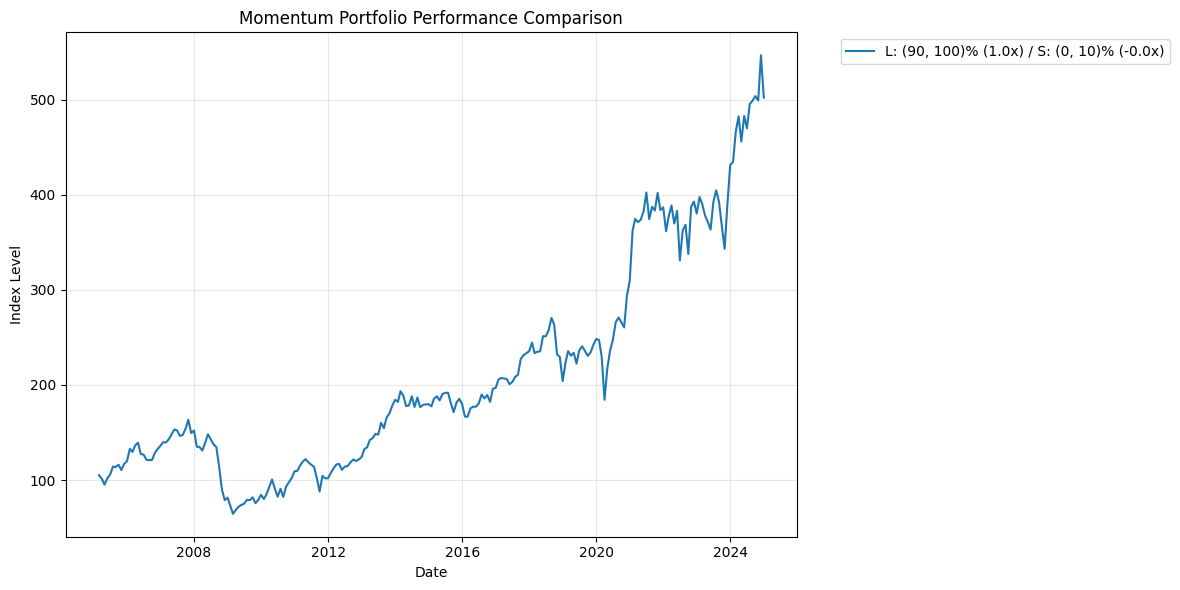

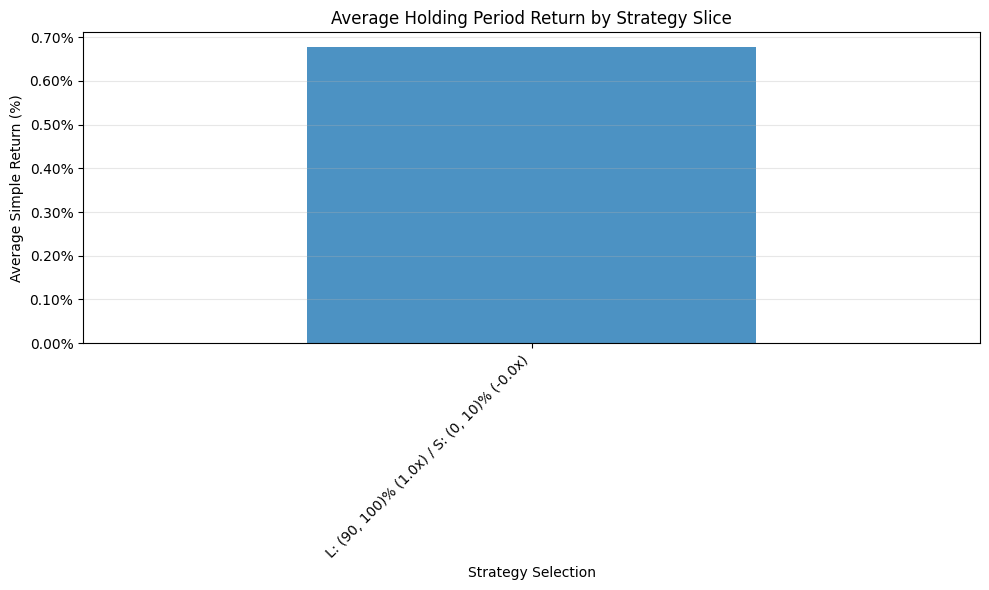

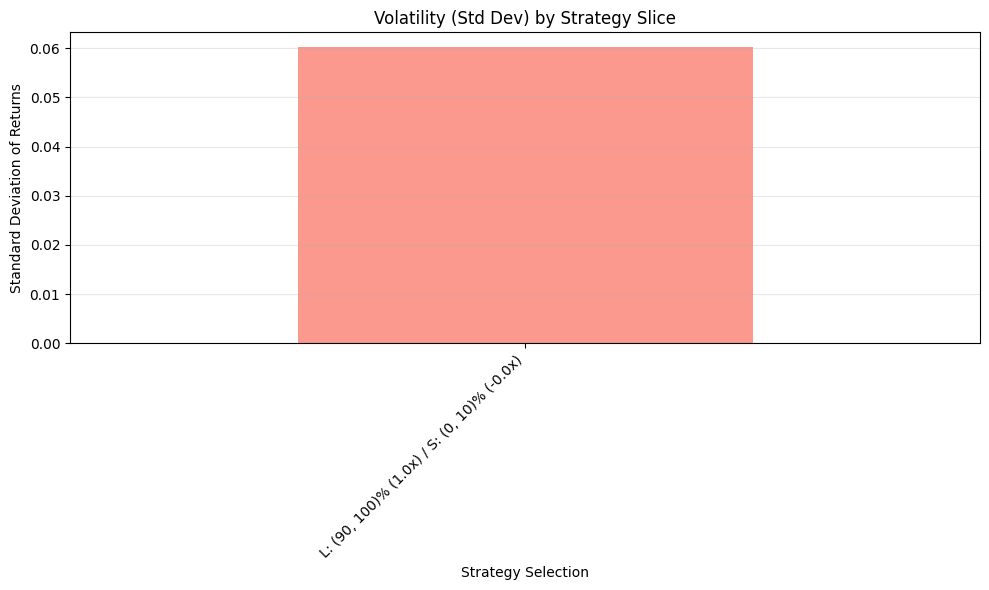


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-0.0x)       8.44%          20.65%         0.41      -60.52%
---------------------------------------------


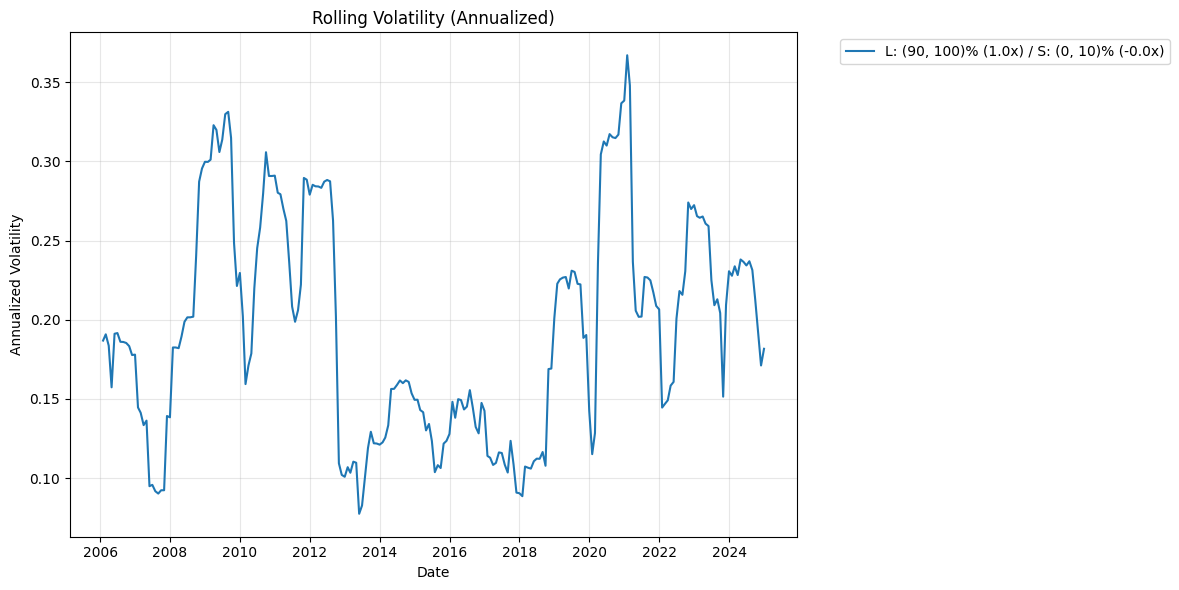


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   -2.71%
Beta:               1.15
Information Ratio:  -0.08
Tracking Error:     11.50%
--------------------------------------------------
Strategy Ann. Ret:  10.78%
Benchmark Ann. Ret: 11.69%
--------------------------------------------------


In [19]:
"""
Long Short Portfolio
100% Long top 10% 
"""
long_short_Portfolio = LongShortMomentumPortfolio(
    START_DATE_LISTED="2020-01-01",
    MIN_AVG_LISTED_PRICE=5.0,
    START_TIME="2000-01-01",
    AGREGATION_PREIOD_OF_RETURNS="ME",
    CLIP_EXTREME_RETURNS=True,
    LOOKBACK_PERIOD=12,
    LAST_PERIODS_TO_IGNORE=1,
    INVESTABLE_BIRTH_PERIODS=60,
    MIN_INCLUDE_PRICE=5.0,
    LONG_PERCENTILE=(90, 100),
    SHORT_PERCENTILE=(0, 10),
    LONG_WEIGHT=1.0,
    SHORT_WEIGHT=-0.0,
    BENCHMARK="SPY",   
)